In [1]:
START_NUM=600;
END_NUM=750;

### Goal: Feature Importance.

The idea is to use the permutation importance to the neural network.
1. Fit the model with all the features of interest.
2. For each column:
  - Randomly permute the values in the column
  - Compute the drop in training RMSE
  - The more important the feature is, theoretically the more is the performance drop.

In [2]:
import tensorflow as tf;
import numpy as np;
import matplotlib.pyplot as plt;
print(tf.__version__);
import pandas as pd;

from sklearn.preprocessing import StandardScaler;
from sklearn.preprocessing import MinMaxScaler;
from sklearn.metrics import mean_squared_error;

2.6.0


In [3]:
pd.set_option('display.max_columns', 300);
pd.set_option('display.max_rows', 300);
tf.keras.backend.set_floatx('float64');

In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0']

In [5]:
MONTHS = 60;
SPLIT = 48; # 2015-2018: training, 2019: testing.
# BATCH_SIZE = 19; # used in NN_v1
BATCH_SIZE = 24;
WINDOW_SIZE = 1;

TEST_LENGTH = MONTHS - SPLIT;

### Data preparation

In [6]:
multi_data = pd.read_csv('../data/full_dataset_unscaled.csv', index_col = 0);
zip_ids = multi_data.index.unique();

multi_data.drop(["City", "State", "Metro", "CountyName", "year", "month", "datetime"],\
                 axis = 1, inplace = True);

multi_data.head()

zri  percent_white  percent_black  percent_asian  percent_hispanic  \
zip                                                                          
1013  946.0       0.714892       0.023829       0.013748          0.230129   
1013  950.0       0.715367       0.024195       0.014023          0.229024   
1013  958.0       0.715842       0.024561       0.014299          0.227919   
1013  958.0       0.716318       0.024927       0.014574          0.226813   
1013  955.0       0.716793       0.025294       0.014850          0.225708   

      percent_native_am  percent_other_race  percent_0_17  percent_18_39  \
zip                                                                        
1013           0.000113            0.004539      0.224062       0.314378   
1013           0.000226            0.004587      0.223443       0.316319   
1013           0.000339            0.004634      0.222823       0.318260   
1013           0.000452            0.004682      0.222204       0.320201   
1013           0.000565            0.004730      0.221584       0.322142   

      percent_40_64  percent_65+  percent_rental_units_vacant  \
zip                                                             
1013       0.316595     0.144965                     0.057735   
1013       0.315346     0.144892                     0.057503   
1013       0.314097     0.144820                     0.057270   
1013       0.312847     0.144748                     0.057038   
1013       0.311598     0.144675                     0.056805   

      percent_rental_units_occupied  percent_graduate_deg  percent_bachelors  \
zip                                                                            
1013                       0.942265              0.029555           0.062456   
1013                       0.942497              0.029598           0.062682   
1013                       0.942730              0.029641           0.062908   
1013                       0.942962              0.029684           0.063134   
1013                       0.943195              0.029727           0.063359   

      percent_associates  percent_highschool  percent_less_highschool  \
zip                                                                     
1013            0.257328            0.383459                 0.218492   
1013            0.255708            0.385186                 0.217890   
1013            0.254088            0.386912                 0.217289   
1013            0.252468            0.388639                 0.216687   
1013            0.250848            0.390365                 0.216086   

      percent_commute_public_transport  percent_commute_less_30  \
zip                                                               
1013                          0.022609                 0.731245   
1013                          0.023198                 0.733361   
1013                          0.023787                 0.735477   
1013                          0.024375                 0.737593   
1013                          0.024964                 0.739709   

      percent_buildings_less_10_units  percent_buildings_10_19_units  \
zip                                                                    
1013                         0.883422                       0.030202   
1013                         0.883598                       0.030477   
1013                         0.883775                       0.030752   
1013                         0.883952                       0.031027   
1013                         0.884128                       0.031302   

      percent_buildings_20_49_units  percent_buildings_50+_units  \
zip                                                                
1013                       0.036863                     0.049514   
1013                       0.036368                     0.049557   
1013                       0.035873                     0.049601   
1013                       0.035378                     0.049644   
1013            

In [7]:
FEATURES = multi_data.shape[1] - 1;

feature_name = list(multi_data.columns);

### Utility functions

In [8]:
@tf.autograph.experimental.do_not_convert
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series); #(43,)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True);
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)); #(13,43)
    dataset = dataset.shuffle(shuffle_buffer)\
                     .map(lambda window: (window[:-1, 1:], window[-1][0]));
    dataset = dataset.batch(batch_size).prefetch(1);
    return dataset;

In [9]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time Frame")
    plt.ylabel("ZRI")
    plt.grid(True)

### Neural network center

In [10]:
def NN_model(dataset, termination=0, test = None):
    tf.keras.backend.clear_session();
    # dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

    class myCallbacks(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            mse = logs.get("mse");
            if(mse < termination):
                print("\nGot an mse at {:.4f} in epoch {} and stopped training\n".format(mse, epoch));
                self.model.stop_training = True;
            
    callback = myCallbacks();
    
    model = tf.keras.models.Sequential([
#         tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
#                           input_shape=[None]),
#       tf.keras.layers.Conv1D(filters=32, kernel_size=3,
#                           strides=1, padding="causal",
#                           activation="relu",
#                           input_shape=[None, WINDOW_SIZE, FEATURES+1]),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True, input_shape = [None, WINDOW_SIZE, FEATURES])),
        #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
        # tf.keras.layers.SimpleRNN(8, return_sequences=True),
        #  tf.keras.layers.SimpleRNN(16, return_sequences=True),
        tf.keras.layers.Dense(8, activation="relu"),
    #   tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(1)
        # tf.keras.layers.Lambda(lambda x: x * 2.0)
    ]);
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=3e-4, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(),
                  optimizer="adam",
                  metrics=["mae", "mse"])

    model.build((None,WINDOW_SIZE,FEATURES))
    # model.summary()

    if not test: history = model.fit(dataset, epochs=500, callbacks = [callback], verbose = 0);
    else: history = model.fit(dataset, epochs=500, validation_data=test,\
                              callbacks=[callback], verbose = 0);
    return model;

In [11]:
def NN_forecast(model, series_transformed):
    forecast = []
    results = []
    for time in range(MONTHS - WINDOW_SIZE):
        forecast.append(model.predict(series_transformed[np.newaxis, time:time + WINDOW_SIZE, 1:]))

    results = [float(x[-1][0]) for x in forecast];
    actual = list(series_transformed[WINDOW_SIZE:, 0]);
    
    return results, actual;

In [12]:
@tf.autograph.experimental.do_not_convert
def NN_test(ZONE, termination=0, plot=False):
    '''
    Input: ZONE
    Output: the RMSE of a NN model on the predicted train, partially predicted test, and complete predicted test.
    '''
    # Collection of data
    series_frame = multi_data[multi_data.index == ZONE];
    # series_frame.sort_values("datetime", ascending = True, inplace = True);
    
    # Standardization
    scaler = MinMaxScaler();
    series_transformed = scaler.fit_transform(series_frame);
    
    # Train test split
    series_train = series_transformed[:SPLIT];
    series_test = series_transformed[SPLIT-WINDOW_SIZE:];
    
    # Window the training set to make input of the NN
    dataset_train = windowed_dataset(series_train, WINDOW_SIZE, BATCH_SIZE, 60);
    # dataset_test = windowed_dataset(series_test, WINDOW_SIZE, BATCH_SIZE, 60);
    
#     for x, y in dataset_train:
#         print(np.array(x).shape, np.array(y).shape);
    
    model = NN_model(dataset_train, termination);
    
    time_train = list(range(SPLIT));
    time_test = list(range(SPLIT, MONTHS));
    
    # Forecasting
    results, actual = NN_forecast(model, series_transformed);
    
    # Compute MSE
    MSE_train = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5 * scaler.data_range_[0];
    MSE_test = mean_squared_error(actual[-TEST_LENGTH:], results[-TEST_LENGTH:])**0.5 * scaler.data_range_[0];
    
    if plot: # If the plot option is selected, plot the graph.
        time_actual = range(WINDOW_SIZE, MONTHS);
        plt.figure(figsize=(10, 6))
        plot_series(time_actual, np.array(actual)*scaler.data_range_[0]+scaler.data_min_[0]);
        plot_series(time_actual, np.array(results)*scaler.data_range_[0]+scaler.data_min_[0]);
        plt.show();

    return MSE_train, MSE_test, model, scaler, series_transformed;

### The script


Got an mse at 0.0024 in epoch 66 and stopped training



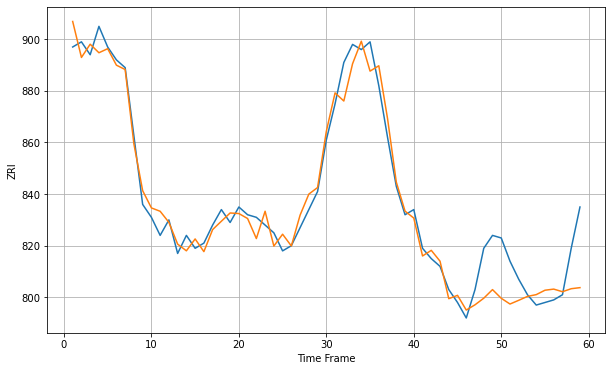

Wall time: 9.86 s
32209 5.473106590114804 15.768287658662324


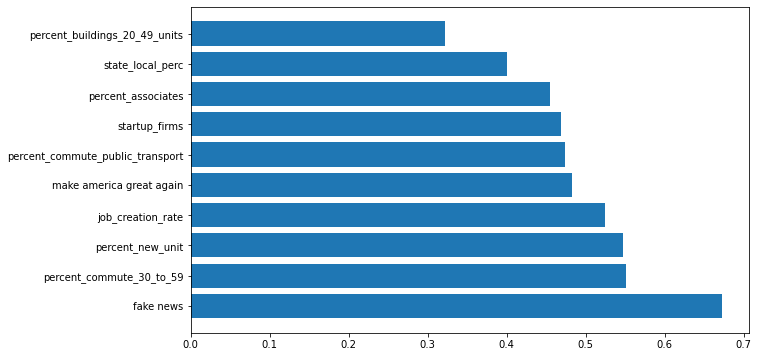


Got an mse at 0.0025 in epoch 38 and stopped training



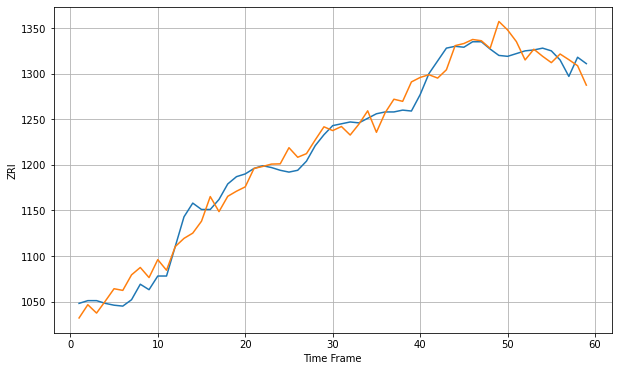

Wall time: 9.1 s
32224 14.624523273245076 17.717999524726174


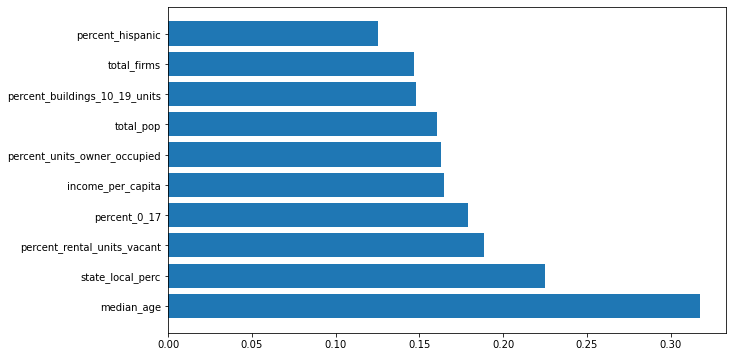


Got an mse at 0.0024 in epoch 73 and stopped training



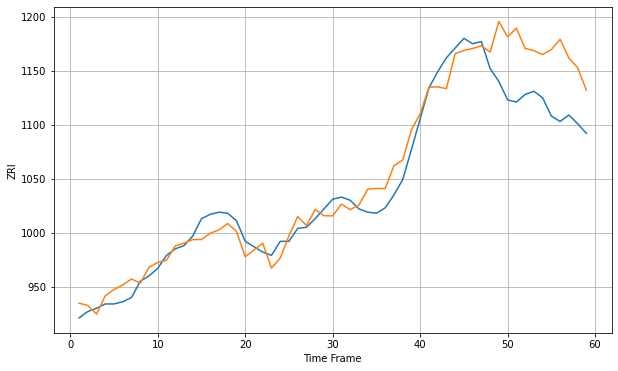

Wall time: 9.94 s
32225 12.635616382833465 52.382355559493014


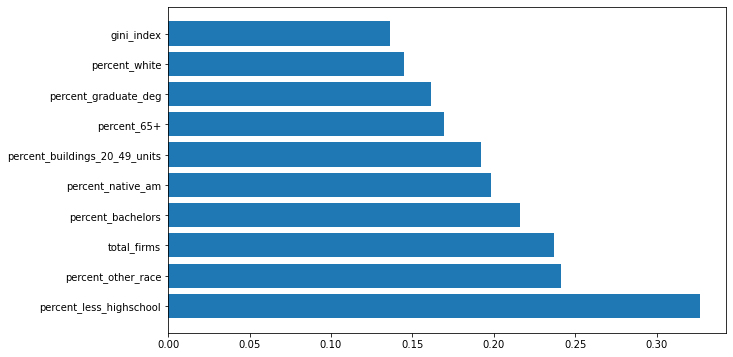


Got an mse at 0.0024 in epoch 38 and stopped training



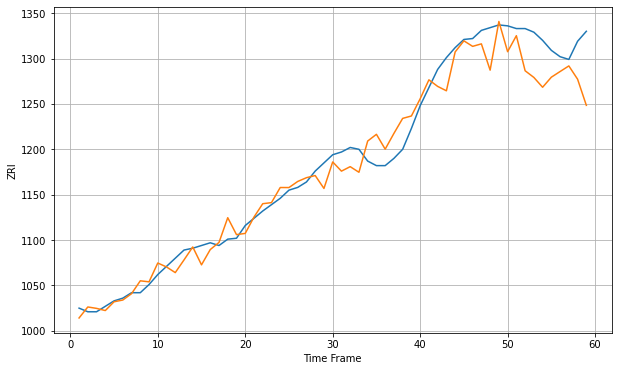

Wall time: 8.83 s
32246 15.308955620127854 40.807481217484586


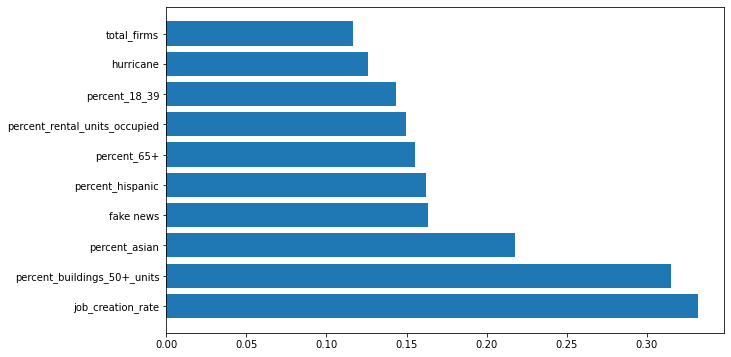


Got an mse at 0.0024 in epoch 38 and stopped training



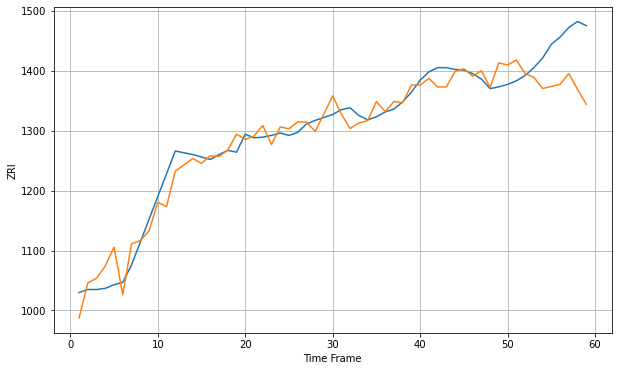

Wall time: 9.04 s
32250 21.999082541009685 66.96886405938005


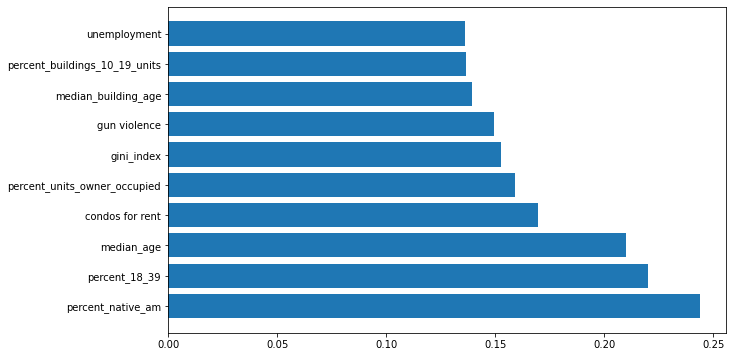


Got an mse at 0.0023 in epoch 45 and stopped training



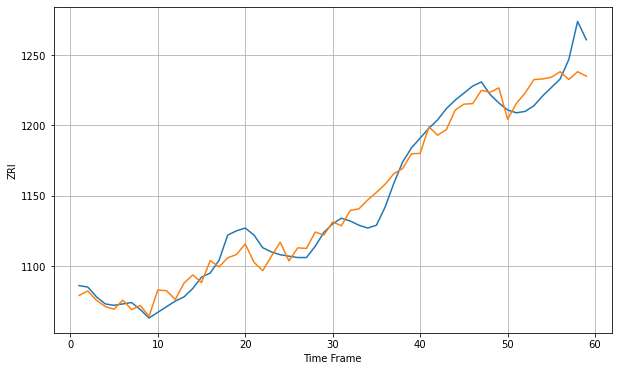

Wall time: 8.93 s
32256 9.99435867240674 16.093806635088818


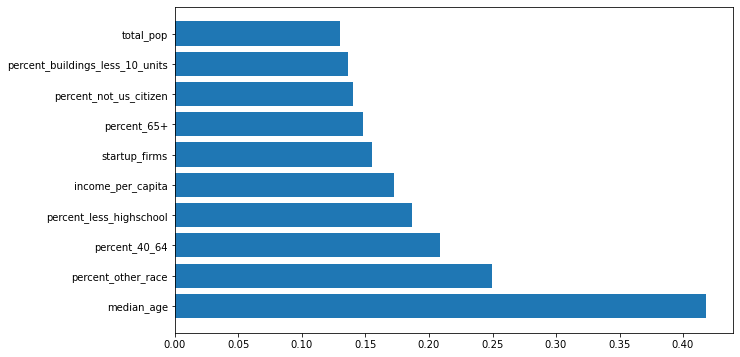


Got an mse at 0.0024 in epoch 32 and stopped training



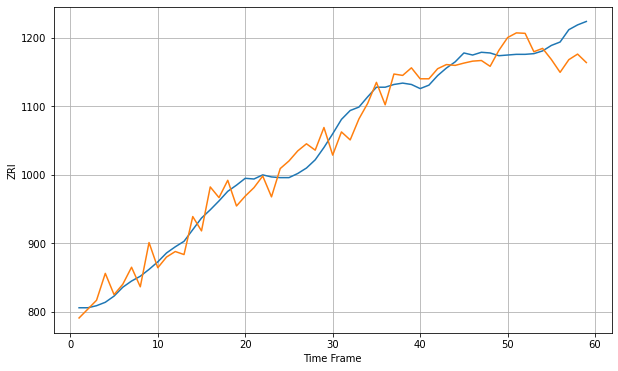

Wall time: 9.22 s
32701 20.506687474984638 32.59305973967162


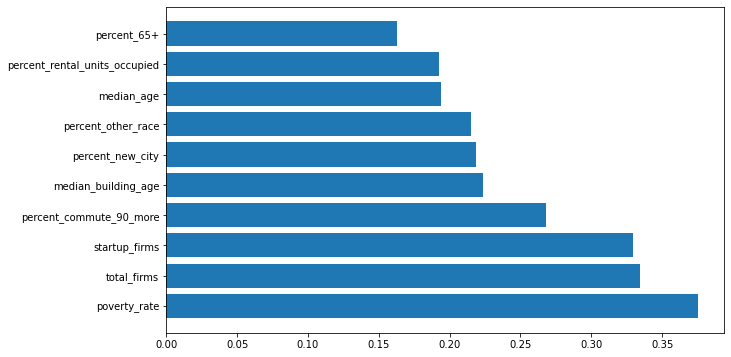


Got an mse at 0.0024 in epoch 30 and stopped training



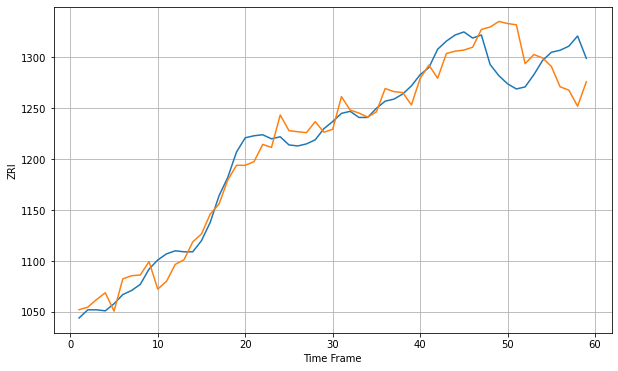

Wall time: 8.82 s
32703 13.673556695347957 42.05060902572573


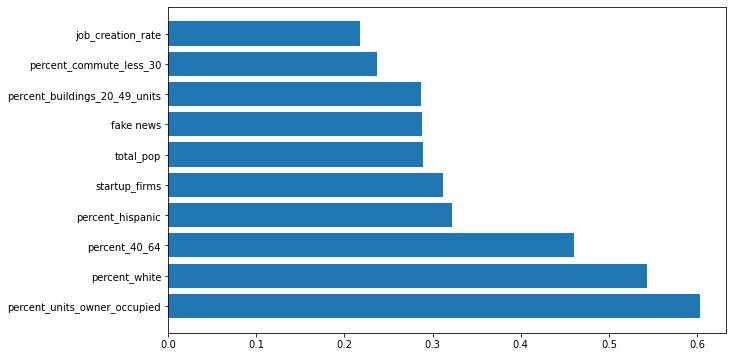


Got an mse at 0.0023 in epoch 22 and stopped training



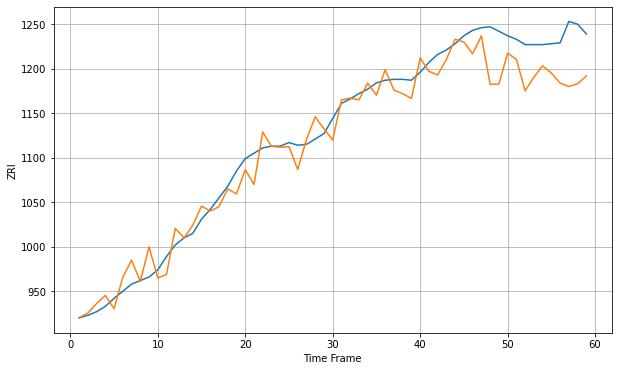

Wall time: 8.56 s
32714 15.480914489446741 48.6130443083382


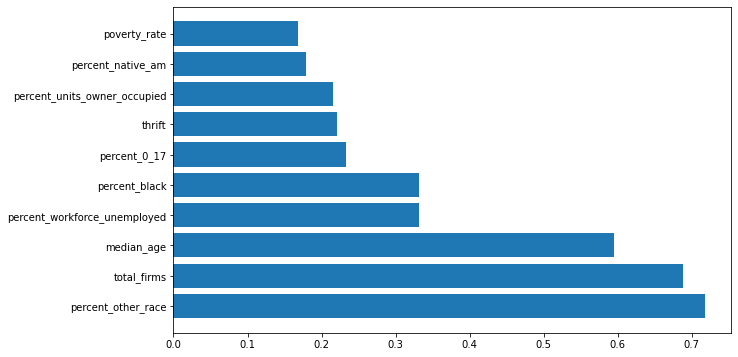


Got an mse at 0.0025 in epoch 88 and stopped training



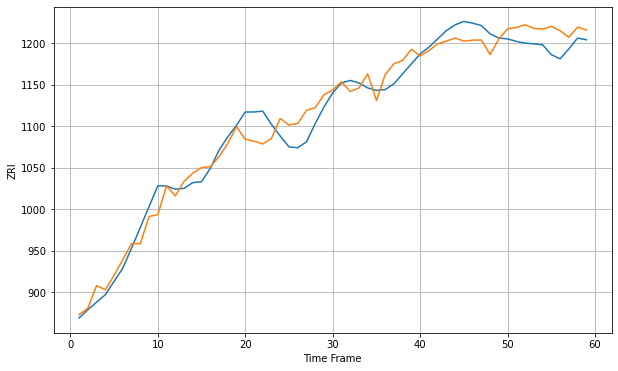

Wall time: 10.7 s
32771 17.937210331578832 20.508464542517466


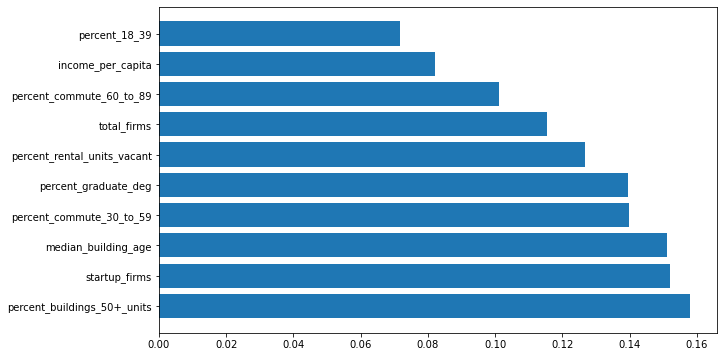


Got an mse at 0.0025 in epoch 34 and stopped training



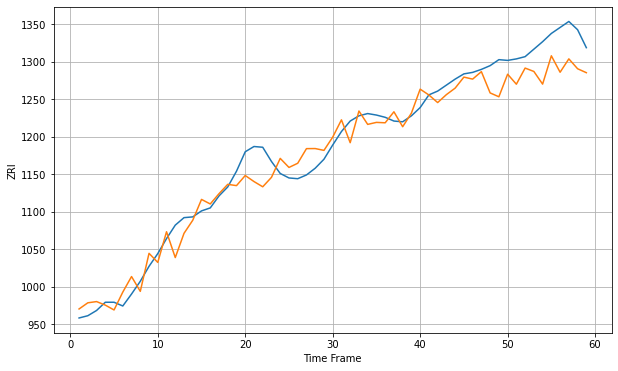

Wall time: 8.6 s
32792 19.49904338455534 41.229824793654366


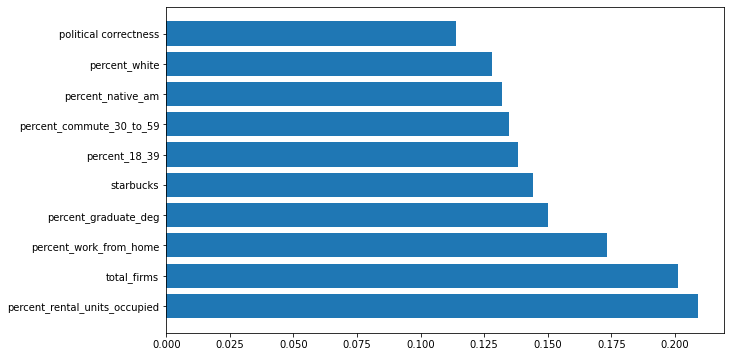


Got an mse at 0.0024 in epoch 35 and stopped training



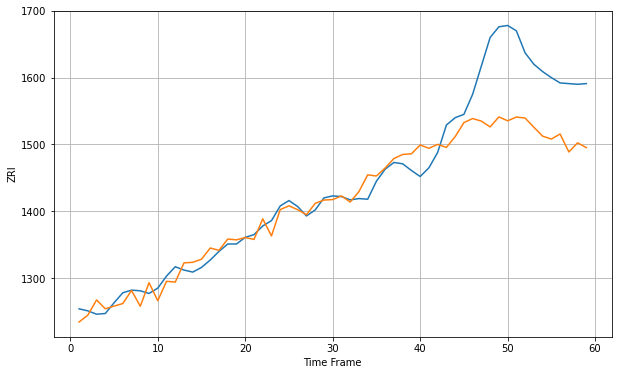

Wall time: 8.48 s
32801 20.943450692264165 108.93338409921435


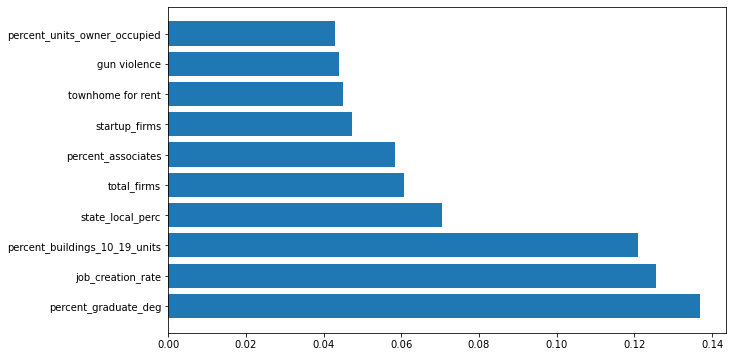


Got an mse at 0.0025 in epoch 46 and stopped training



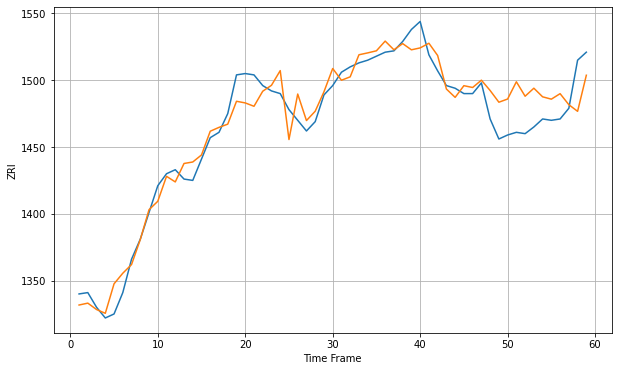

Wall time: 8.82 s
32803 10.986158859392798 25.254732081336872


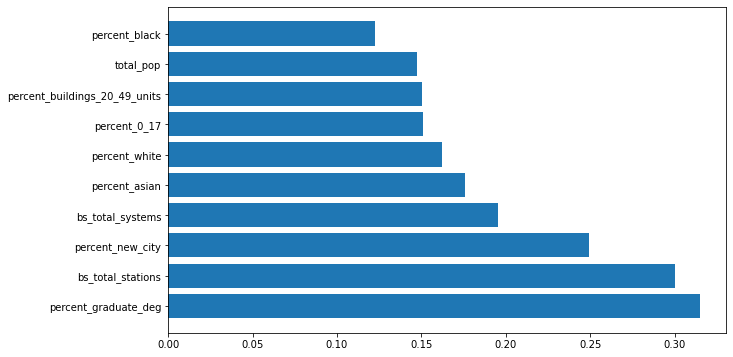


Got an mse at 0.0023 in epoch 21 and stopped training



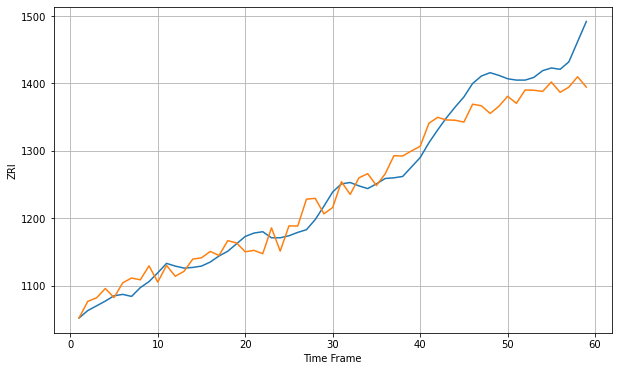

Wall time: 8.21 s
32810 20.748292648009084 45.06259568107378


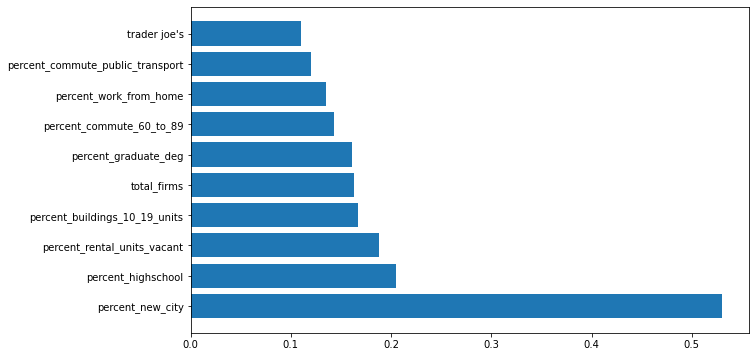


Got an mse at 0.0025 in epoch 42 and stopped training



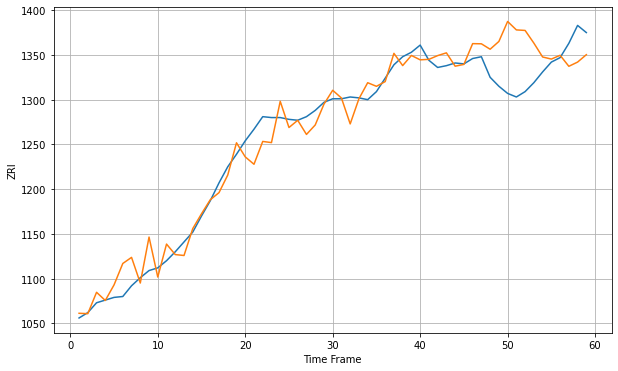

Wall time: 8.77 s
32811 16.3499253969333 46.0618116043881


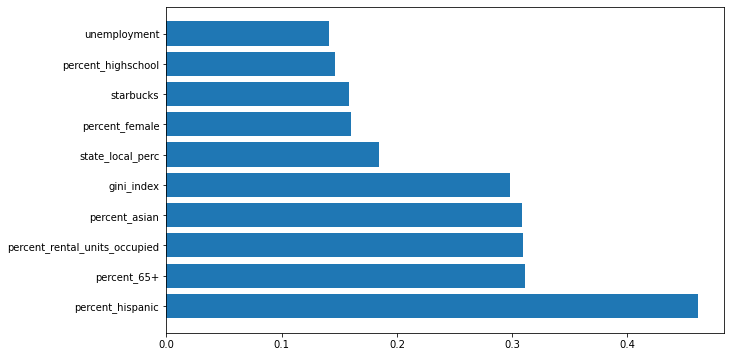


Got an mse at 0.0024 in epoch 16 and stopped training



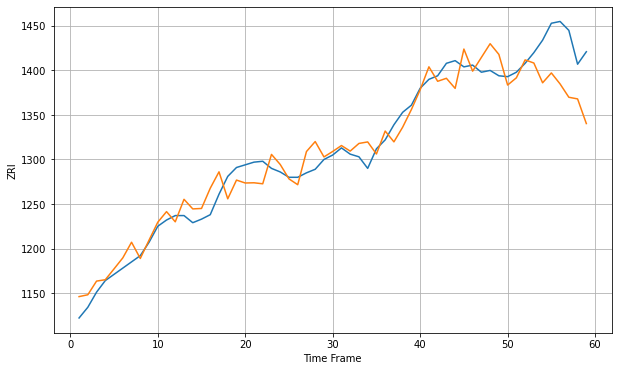

Wall time: 8.02 s
32812 16.324357290453023 46.33100809783994


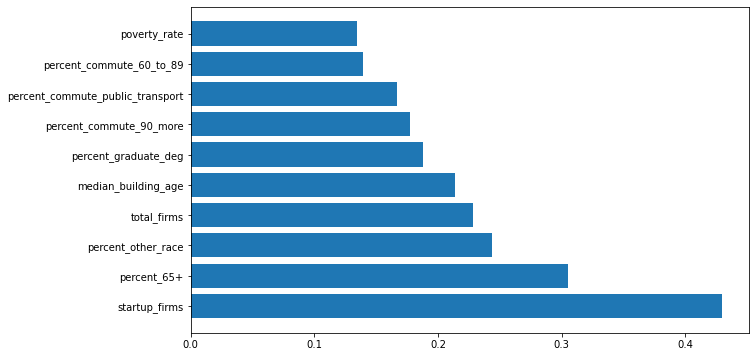


Got an mse at 0.0024 in epoch 55 and stopped training



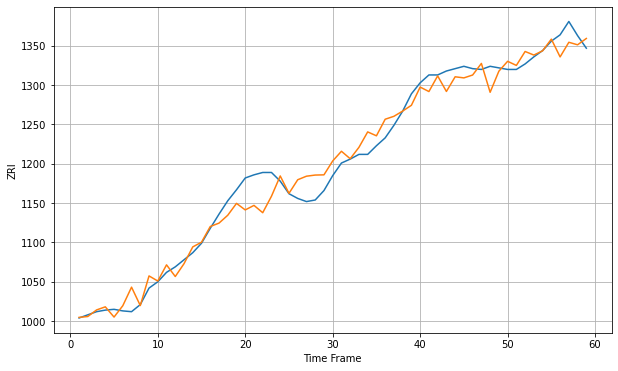

Wall time: 9.14 s
32822 18.65179207387239 16.54276328603451


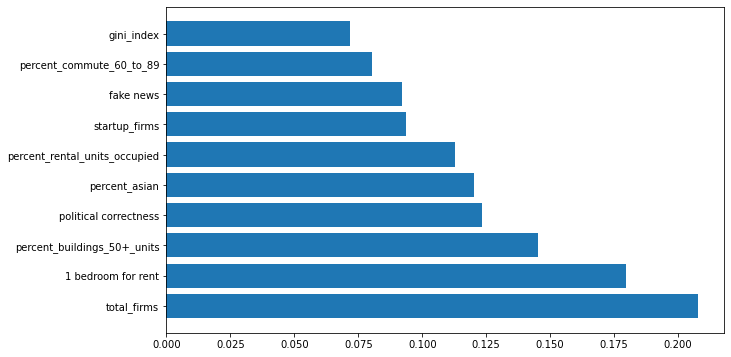


Got an mse at 0.0025 in epoch 38 and stopped training



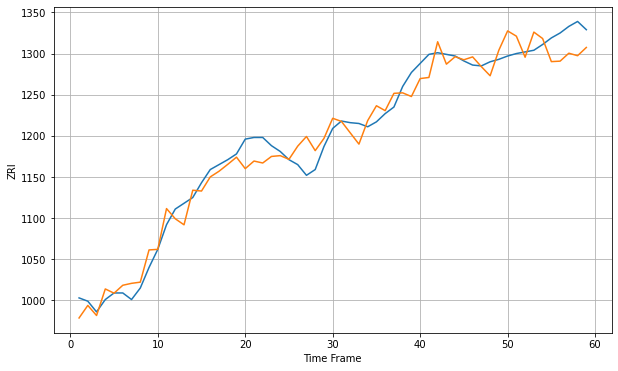

Wall time: 8.52 s
32825 17.331781558657585 25.22290123883054


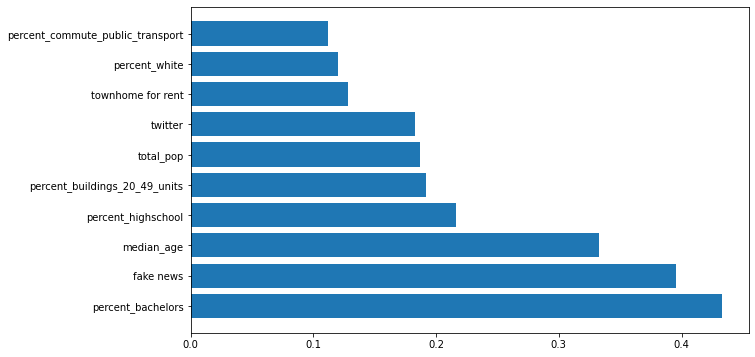


Got an mse at 0.0025 in epoch 46 and stopped training



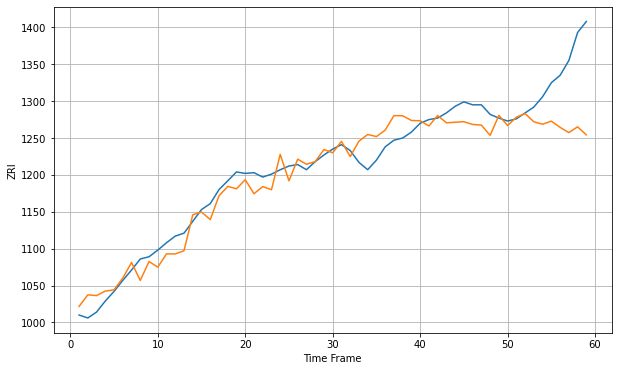

Wall time: 8.8 s
32835 19.77018595535065 70.63946962230543


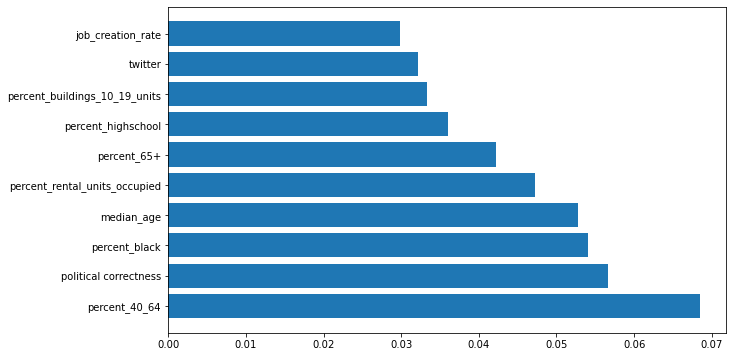


Got an mse at 0.0025 in epoch 29 and stopped training



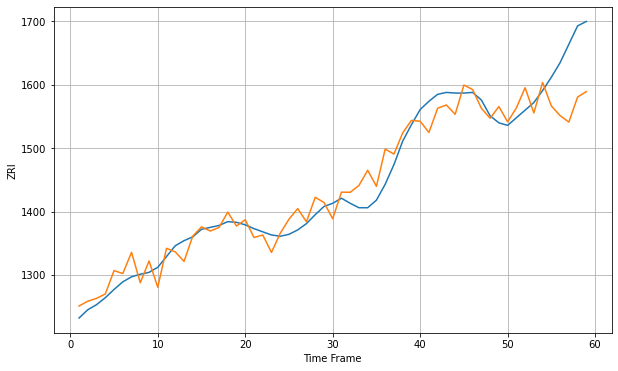

Wall time: 8.38 s
32837 22.98418209094834 65.58753550657346


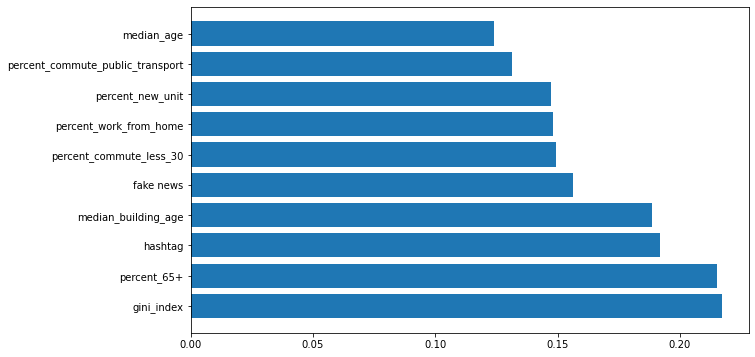


Got an mse at 0.0025 in epoch 24 and stopped training



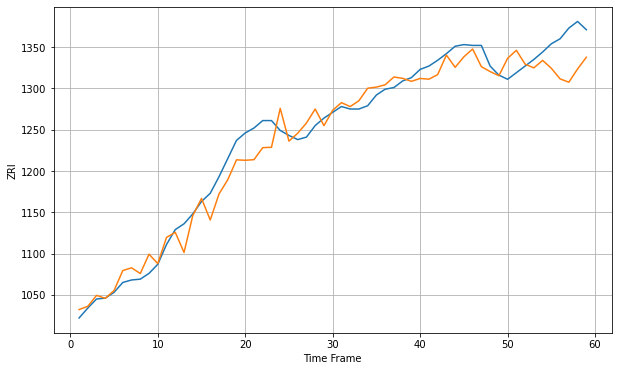

Wall time: 8.34 s
32839 17.596001863807604 33.64915366731227


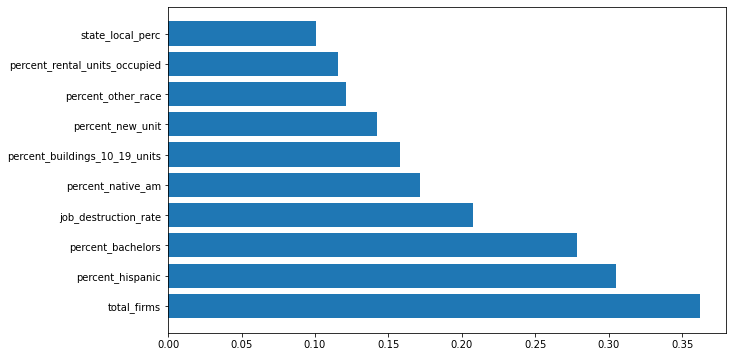


Got an mse at 0.0025 in epoch 30 and stopped training



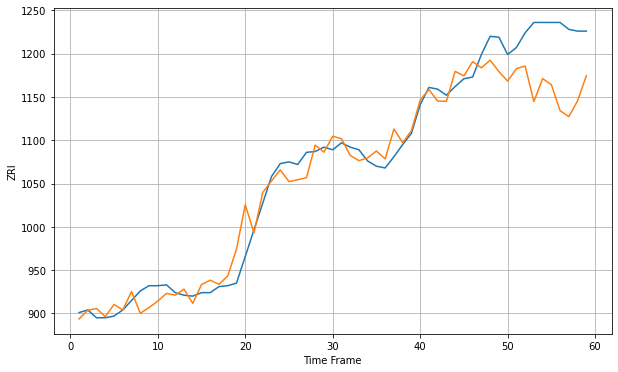

Wall time: 8.39 s
32935 16.612856148429476 66.25731386609381


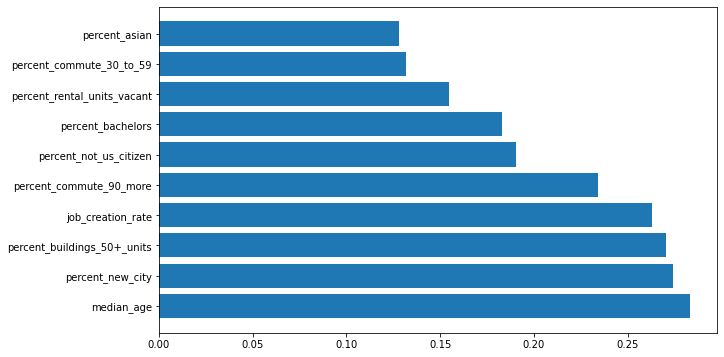


Got an mse at 0.0024 in epoch 88 and stopped training



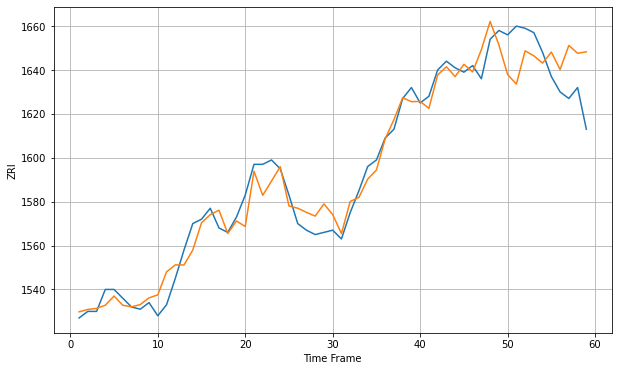

Wall time: 10.2 s
33009 6.63163369004199 17.50419479576779


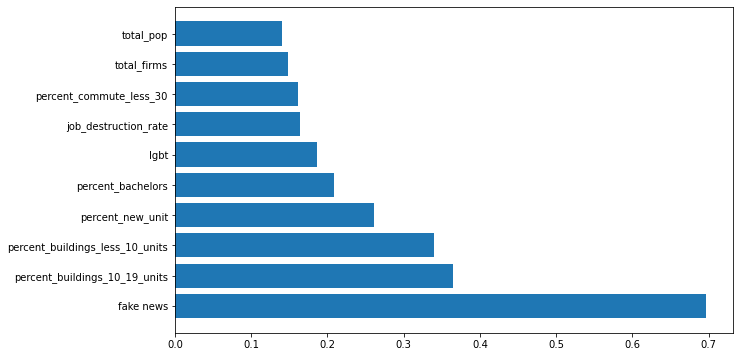


Got an mse at 0.0025 in epoch 110 and stopped training



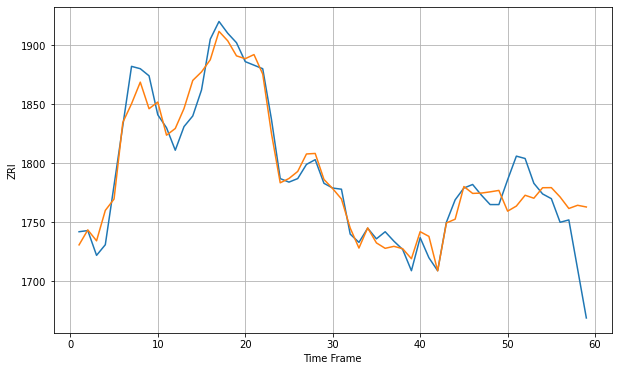

Wall time: 10.6 s
33010 12.3203078834193 36.83229558850214


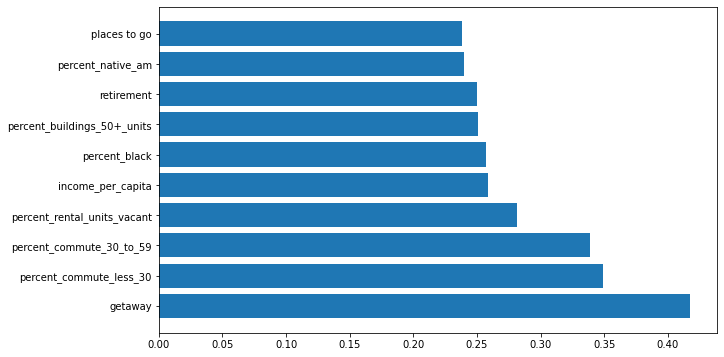


Got an mse at 0.0025 in epoch 246 and stopped training



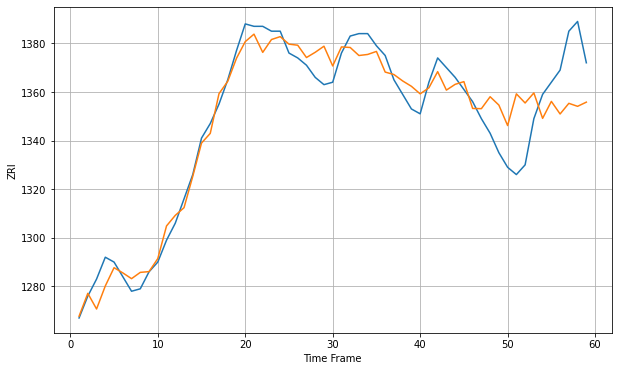

Wall time: 14.7 s
33020 6.052376880468585 21.63694300148494


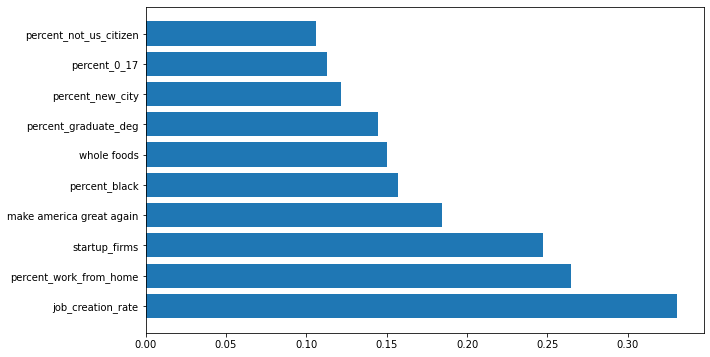


Got an mse at 0.0025 in epoch 55 and stopped training



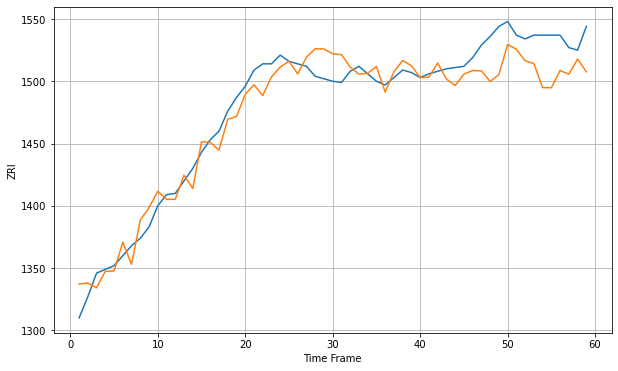

Wall time: 9.12 s
33024 12.446324394680202 29.272460336277994


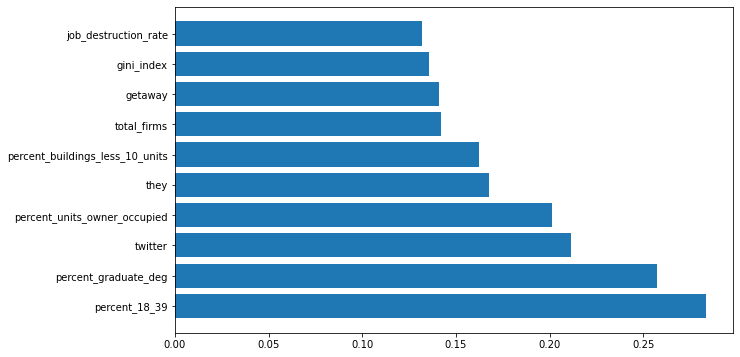


Got an mse at 0.0025 in epoch 78 and stopped training



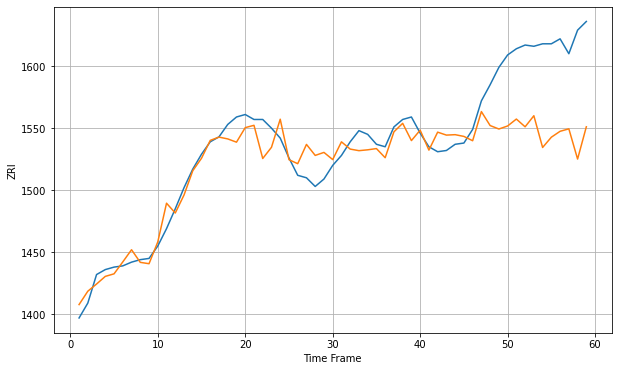

Wall time: 10 s
33025 11.959473795296926 69.15679650487218


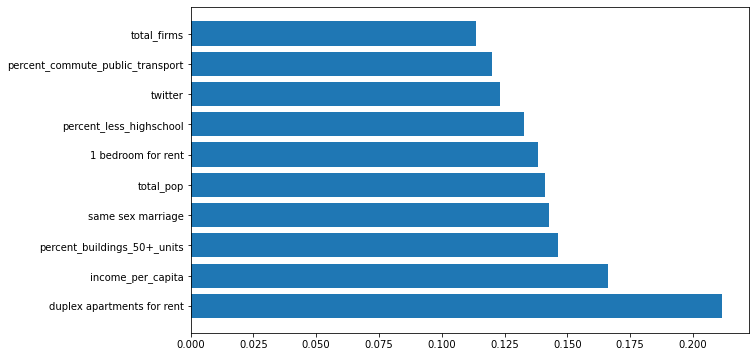


Got an mse at 0.0025 in epoch 68 and stopped training



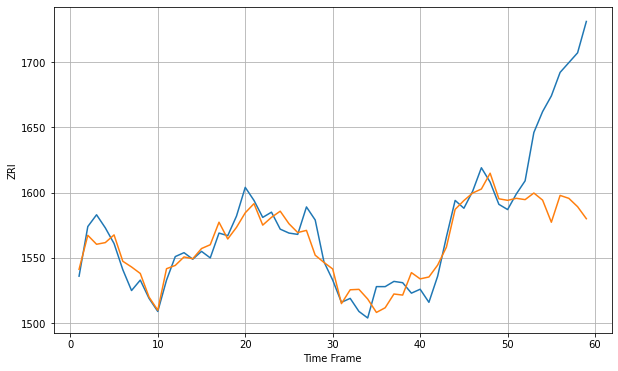

Wall time: 9.46 s
33062 11.182145721402154 77.87399778208852


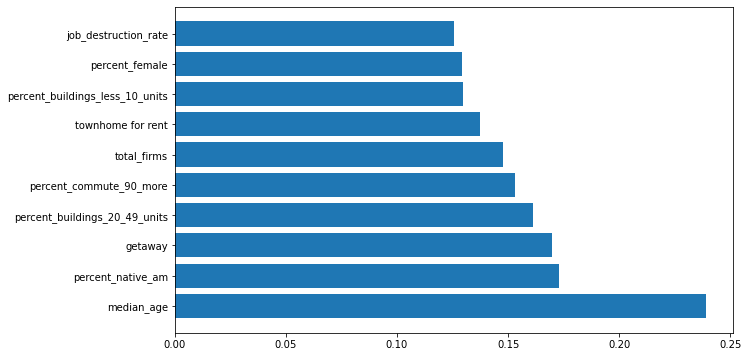


Got an mse at 0.0024 in epoch 48 and stopped training



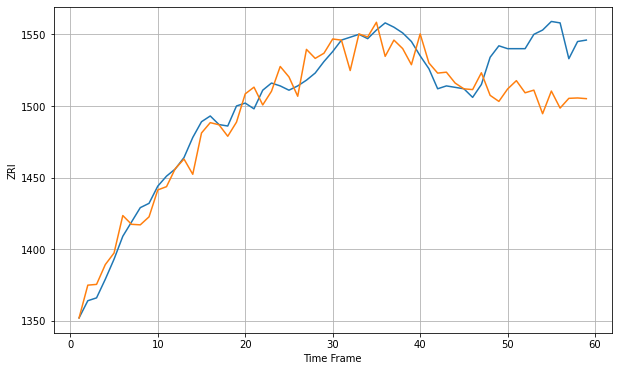

Wall time: 9.02 s
33065 10.639234327945232 40.07782269762268


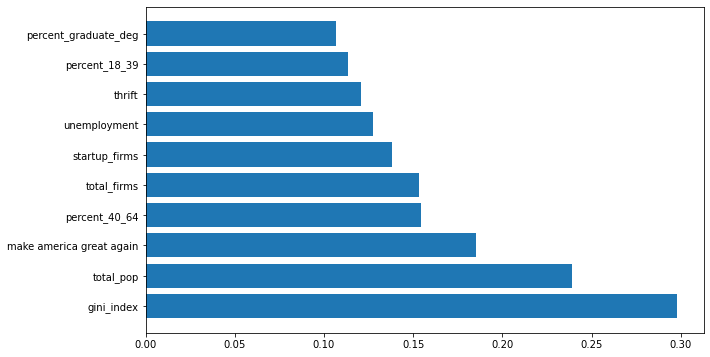


Got an mse at 0.0025 in epoch 99 and stopped training



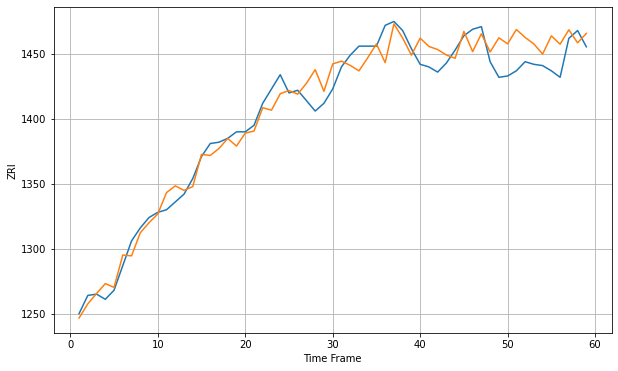

Wall time: 10.3 s
33066 11.302901568047865 20.19876855572221


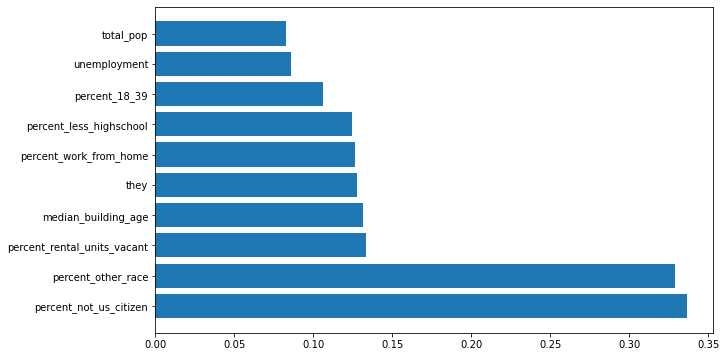


Got an mse at 0.0025 in epoch 190 and stopped training



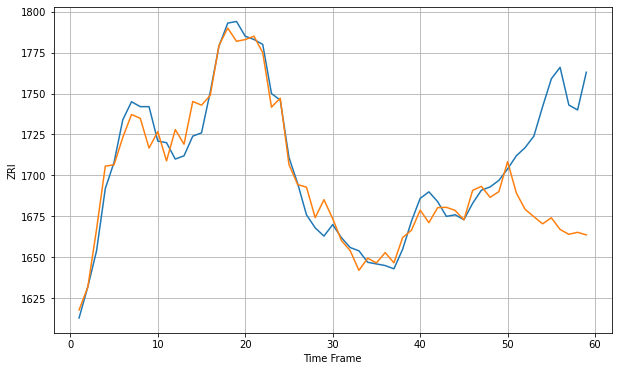

Wall time: 12.9 s
33125 9.747867832083204 63.40386626611286


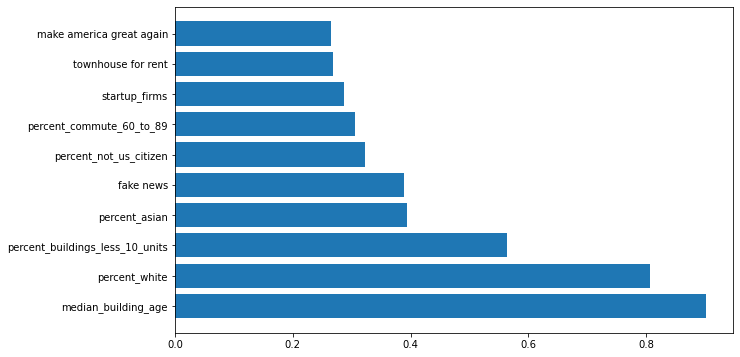


Got an mse at 0.0024 in epoch 44 and stopped training



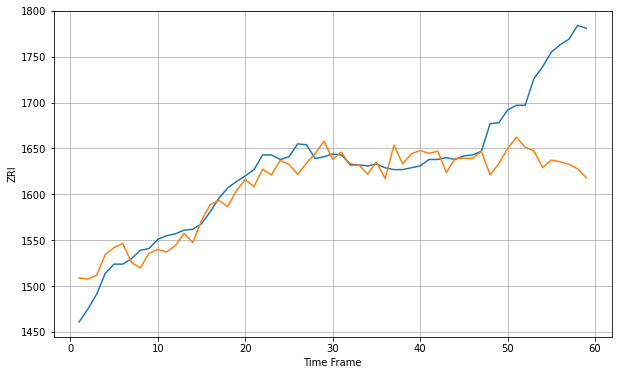

Wall time: 8.79 s
33126 15.8375774544849 103.23171297714097


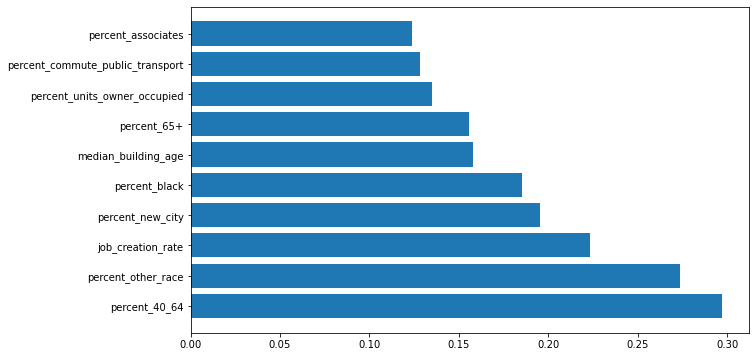


Got an mse at 0.0024 in epoch 108 and stopped training



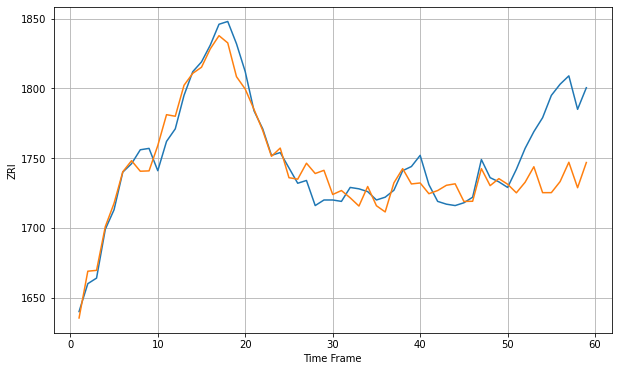

Wall time: 10.5 s
33127 10.632521347158699 44.76633246222892


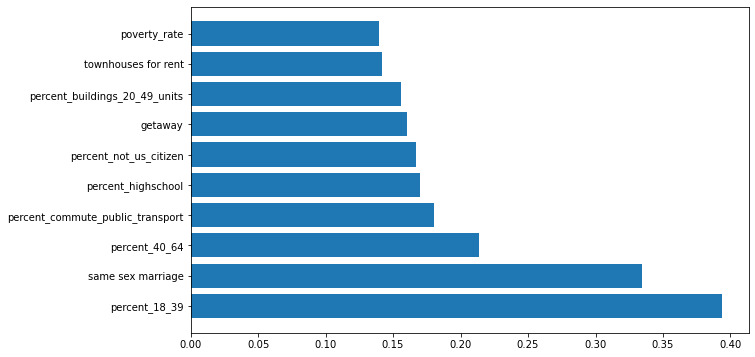


Got an mse at 0.0025 in epoch 65 and stopped training



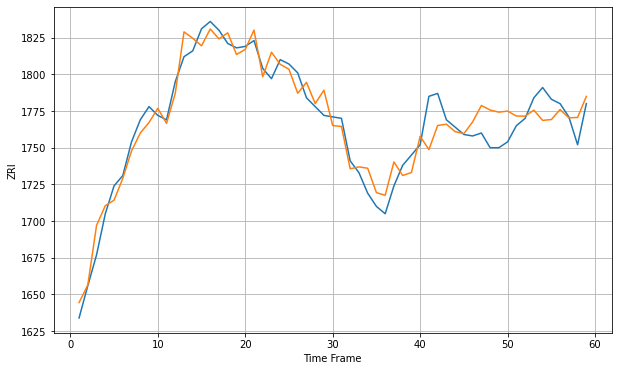

Wall time: 9.4 s
33130 11.328890880224959 15.491228889030213


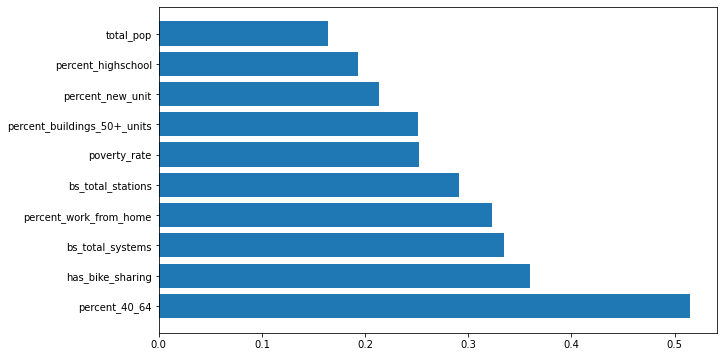


Got an mse at 0.0025 in epoch 141 and stopped training



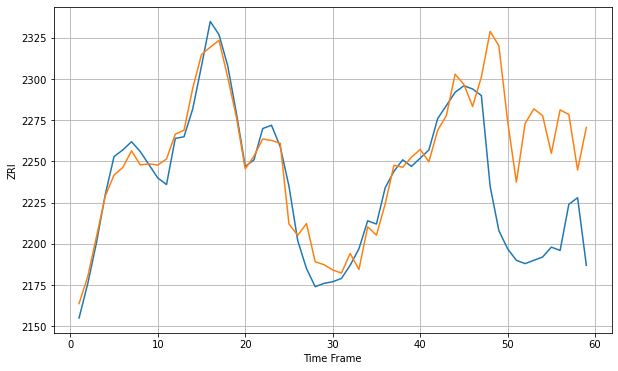

Wall time: 11.6 s
33131 9.312181113947593 78.27566544762101


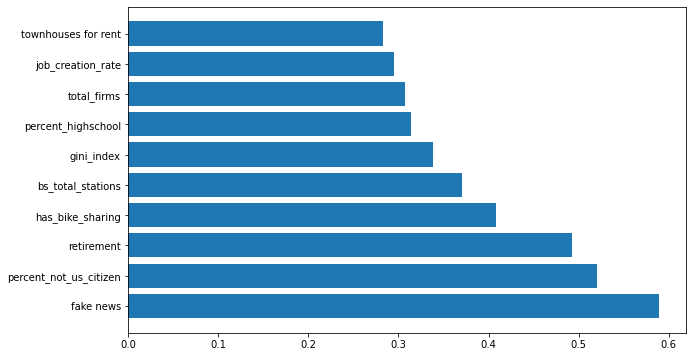


Got an mse at 0.0024 in epoch 128 and stopped training



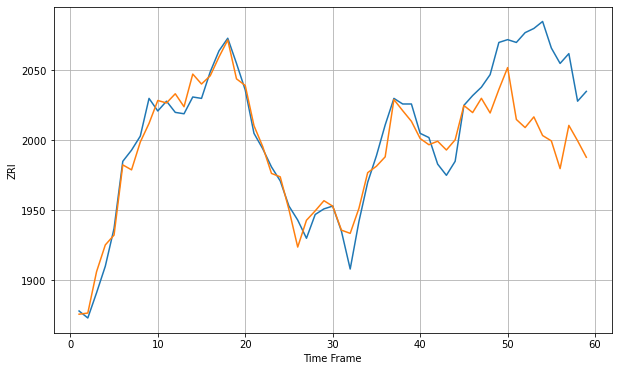

Wall time: 11.1 s
33132 10.423215792687152 54.989238596988606


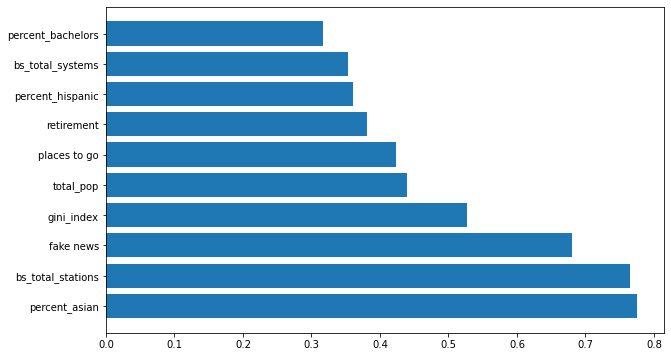


Got an mse at 0.0025 in epoch 91 and stopped training



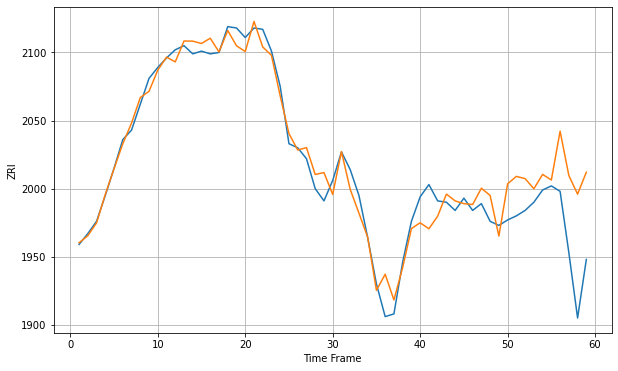

Wall time: 10.2 s
33133 10.434305329820518 41.13115029098411


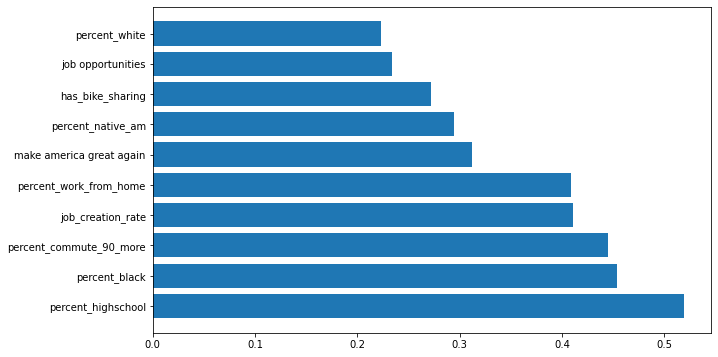


Got an mse at 0.0024 in epoch 131 and stopped training



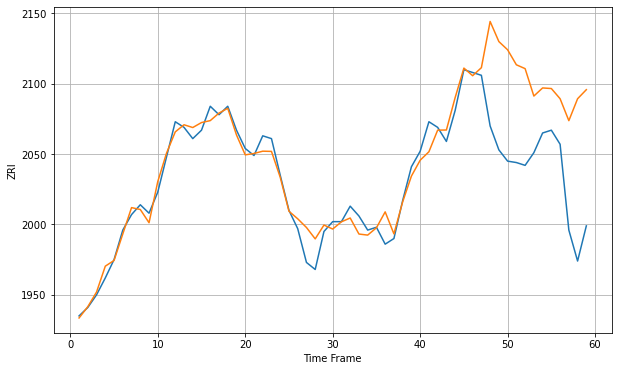

Wall time: 11.2 s
33134 8.53739908390928 71.0289397629533


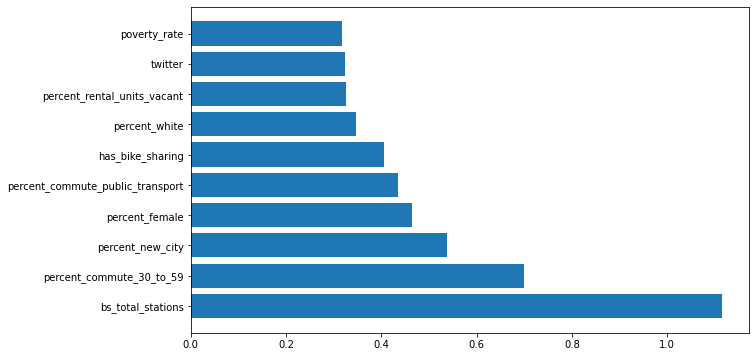


Got an mse at 0.0025 in epoch 230 and stopped training



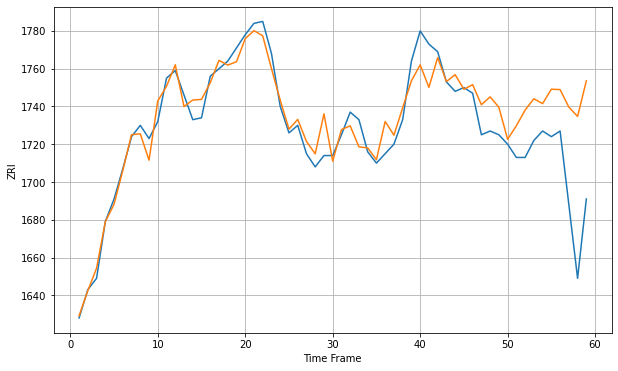

Wall time: 14.1 s
33135 8.46461730689844 37.85460700577354


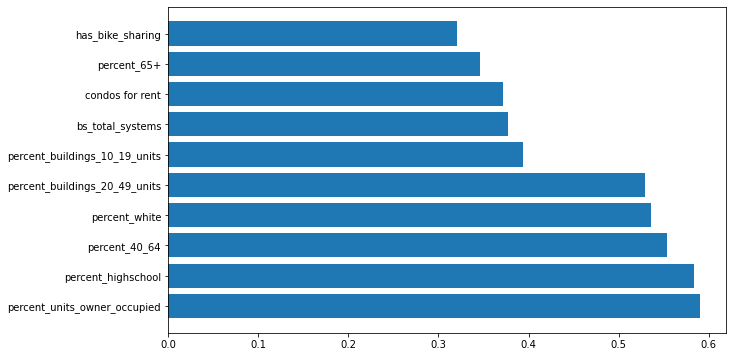


Got an mse at 0.0025 in epoch 64 and stopped training



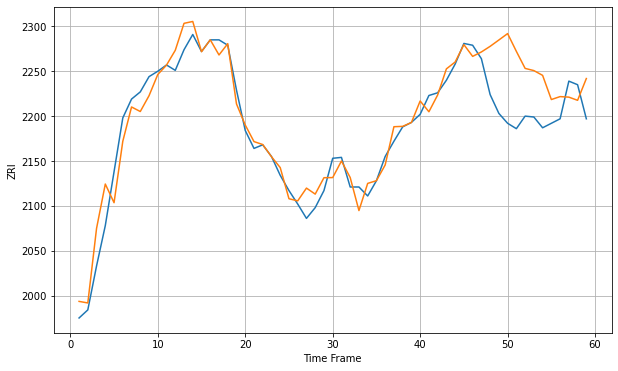

Wall time: 9.46 s
33137 17.190633766310352 57.65219802504799


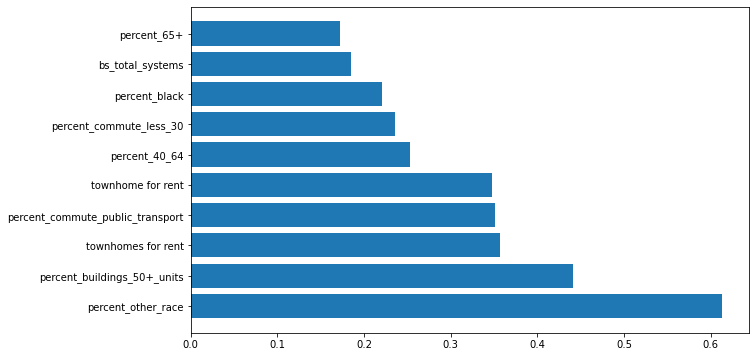


Got an mse at 0.0022 in epoch 72 and stopped training



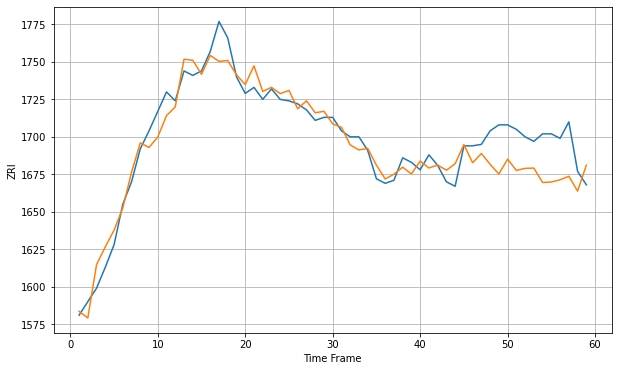

Wall time: 9.49 s
33138 9.03589953386933 26.021565630676985


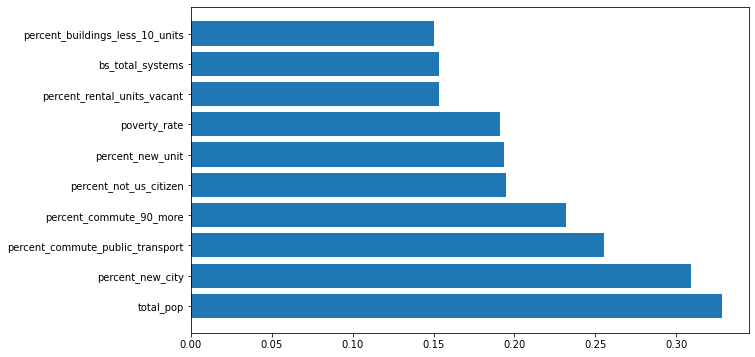


Got an mse at 0.0024 in epoch 40 and stopped training



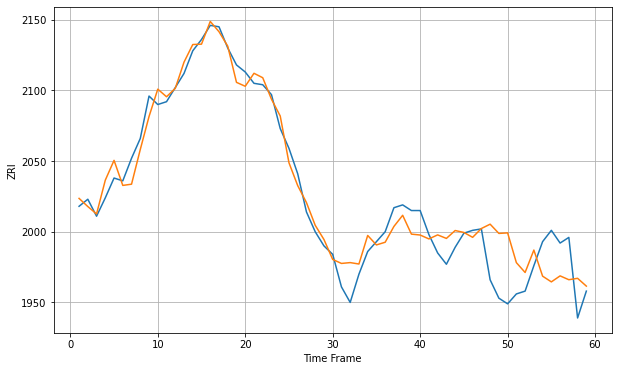

Wall time: 8.78 s
33139 10.018773342377447 30.434425071576626


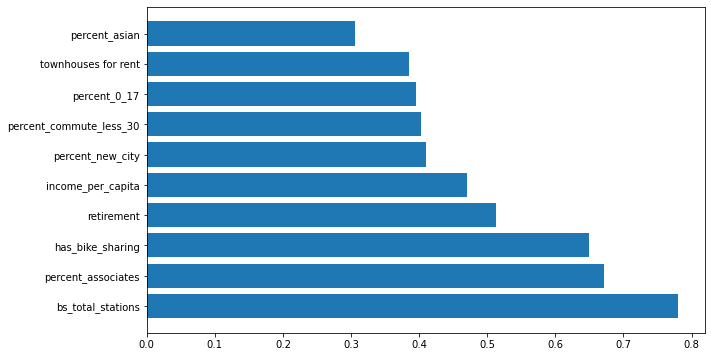


Got an mse at 0.0025 in epoch 64 and stopped training



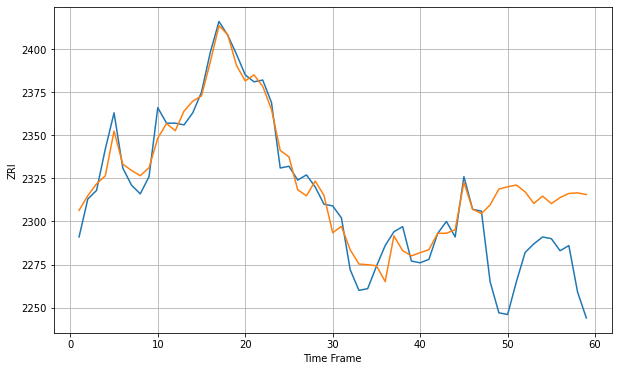

Wall time: 9.58 s
33140 8.477086780905958 49.02629350114877


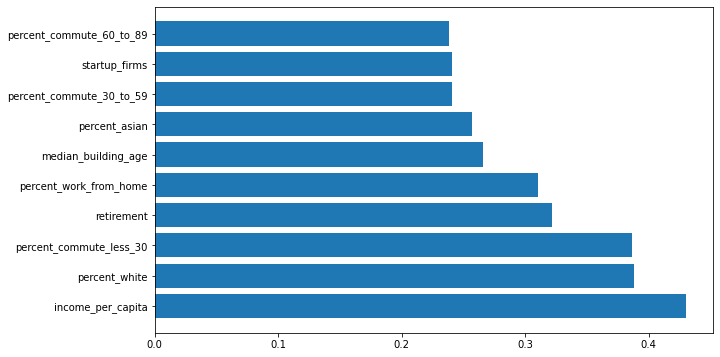


Got an mse at 0.0024 in epoch 104 and stopped training



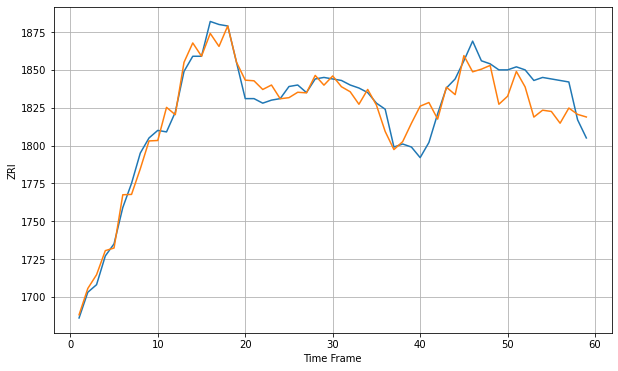

Wall time: 10.5 s
33141 9.9414553244966 17.733932445195826


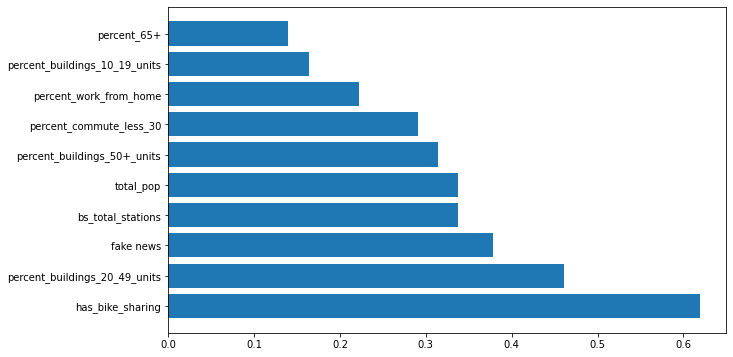


Got an mse at 0.0025 in epoch 67 and stopped training



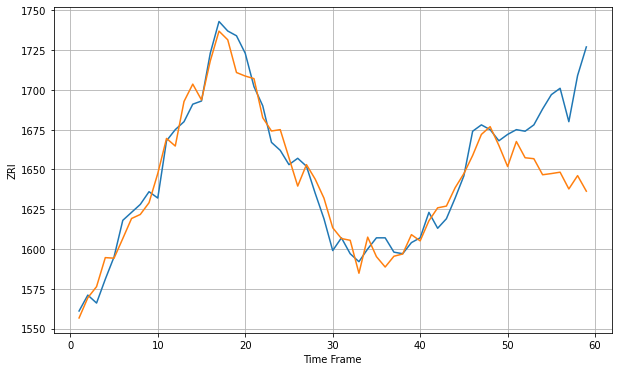

Wall time: 9.47 s
33142 9.658094066729305 42.93960145302608


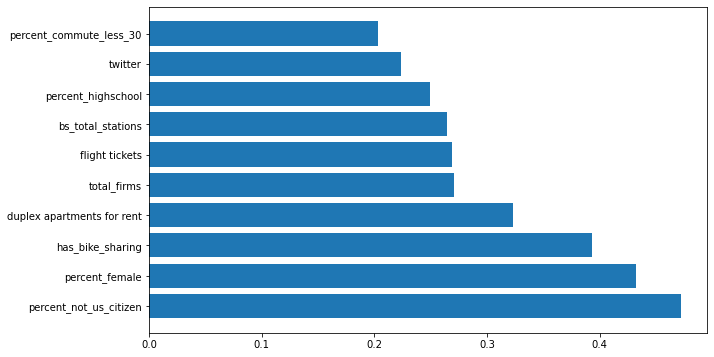


Got an mse at 0.0025 in epoch 128 and stopped training



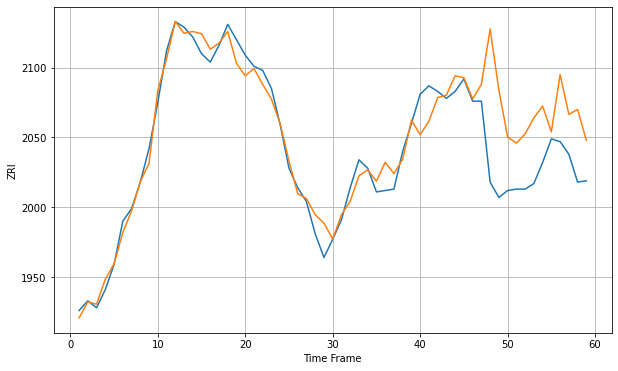

Wall time: 11.3 s
33145 10.200409183724192 52.149845291080695


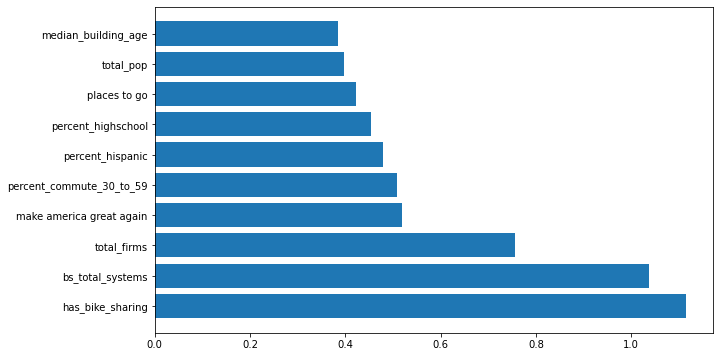


Got an mse at 0.0025 in epoch 169 and stopped training



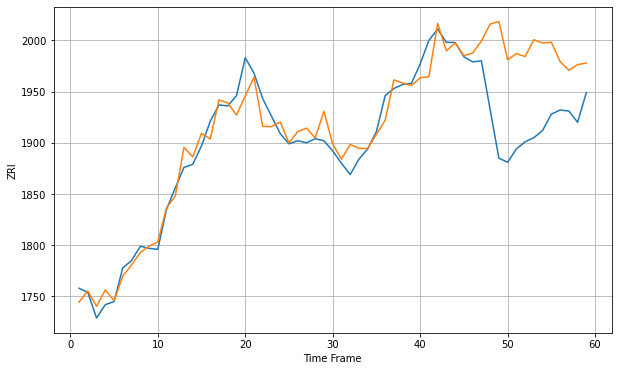

Wall time: 12.3 s
33147 13.977826505171043 81.40928268847458


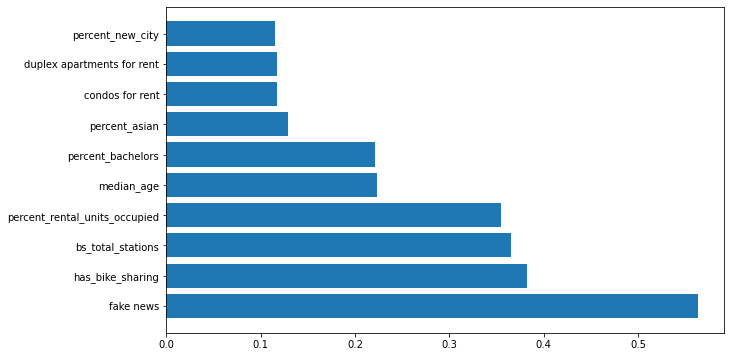


Got an mse at 0.0025 in epoch 177 and stopped training



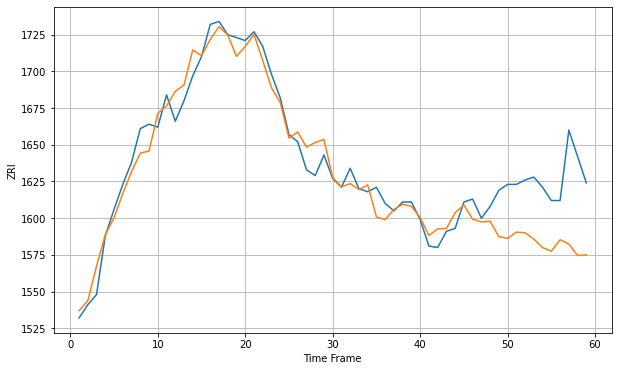

Wall time: 12.6 s
33150 10.015624254196844 43.93724199041653


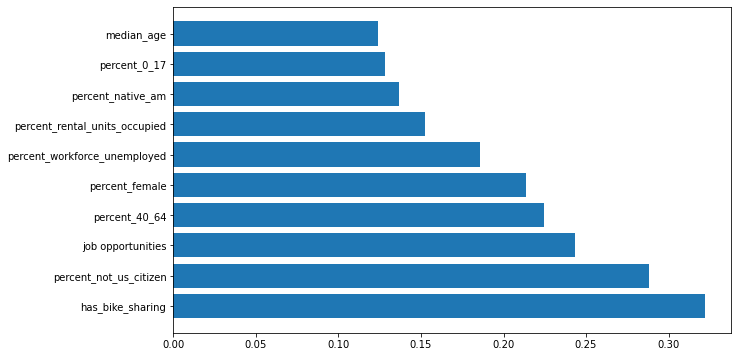


Got an mse at 0.0025 in epoch 88 and stopped training



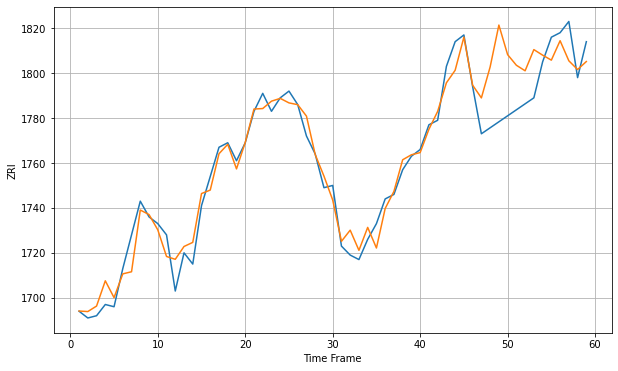

Wall time: 9.89 s
33157 6.524898687094112 20.258182683569757


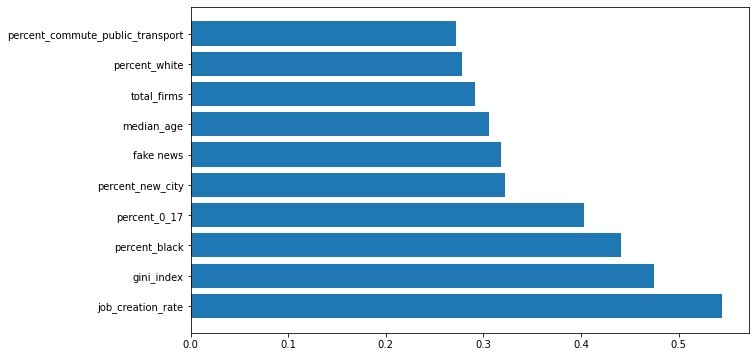


Got an mse at 0.0024 in epoch 127 and stopped training



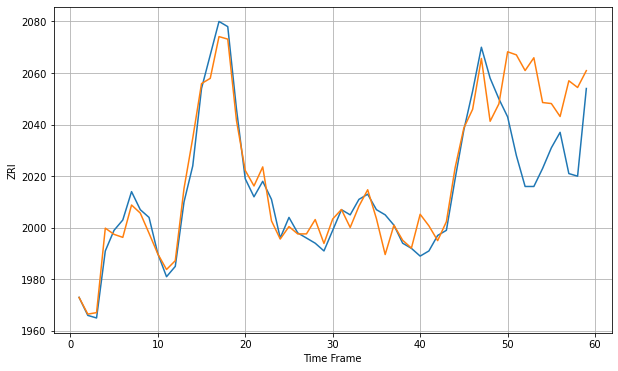

Wall time: 11.2 s
33160 5.683671242600104 29.53956817789134


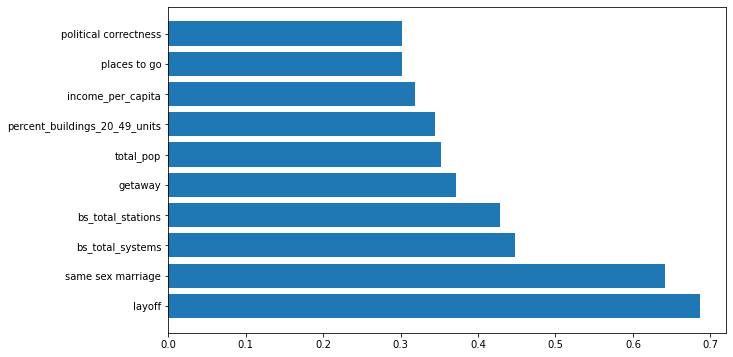


Got an mse at 0.0025 in epoch 136 and stopped training



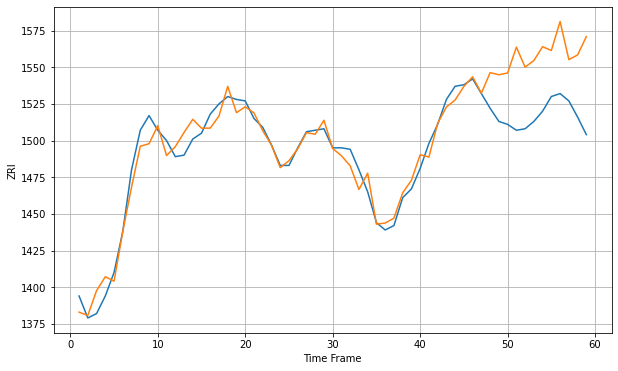

Wall time: 11.4 s
33161 8.063398770985387 42.74405699566891


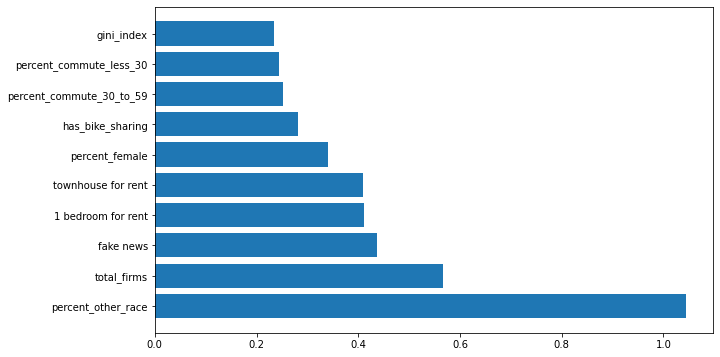


Got an mse at 0.0025 in epoch 72 and stopped training



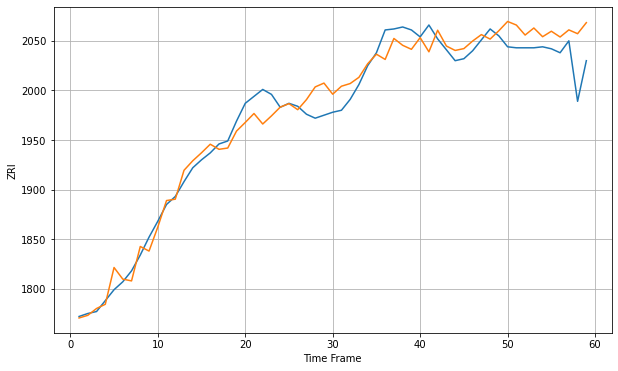

Wall time: 9.72 s
33178 14.712099148516572 27.068465653238114


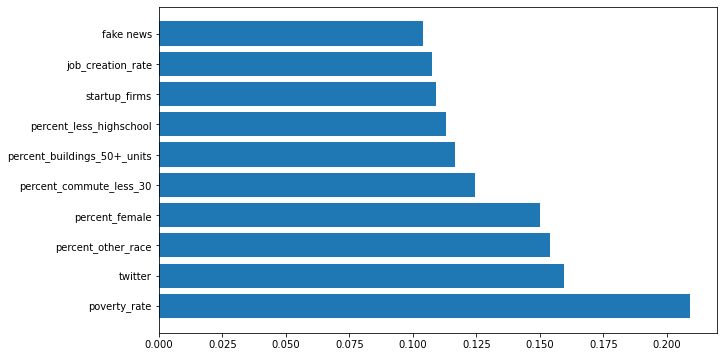


Got an mse at 0.0024 in epoch 91 and stopped training



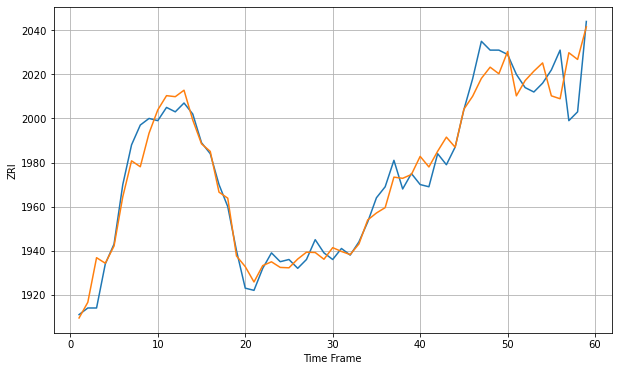

Wall time: 10 s
33180 7.15968069120462 14.723494901534679


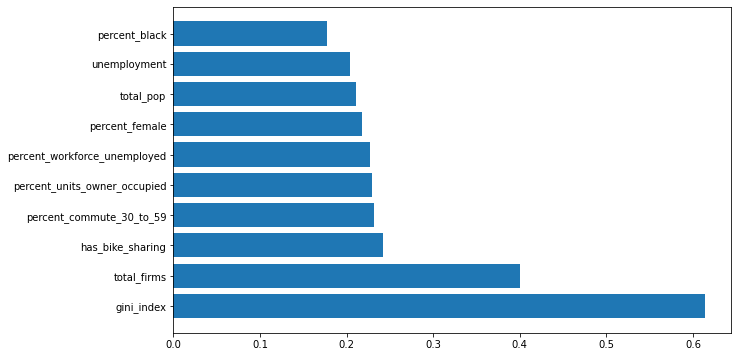


Got an mse at 0.0025 in epoch 57 and stopped training



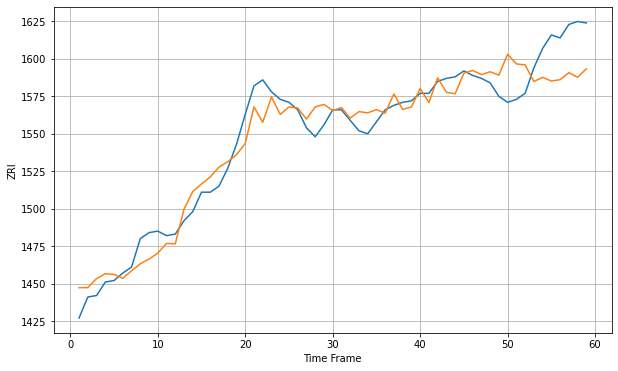

Wall time: 9.24 s
33186 10.380604634150657 25.41065998908477


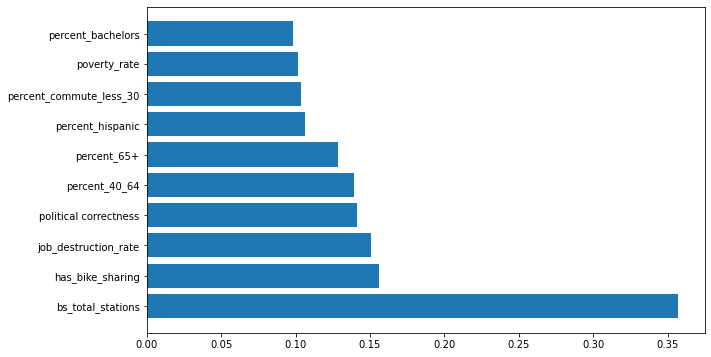


Got an mse at 0.0025 in epoch 51 and stopped training



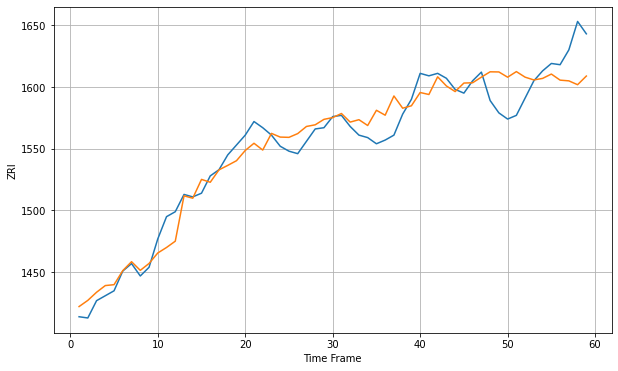

Wall time: 8.89 s
33196 11.899566673520605 27.402907983813122


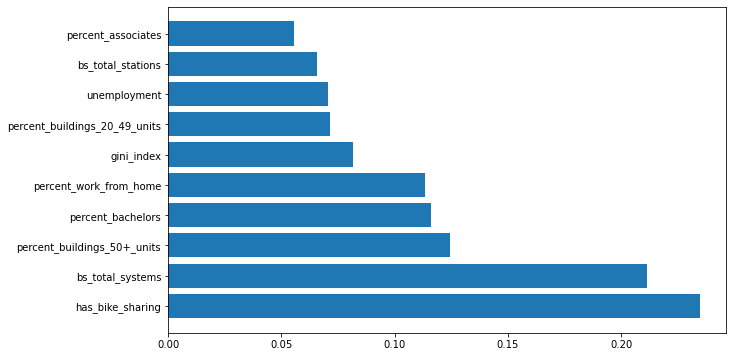


Got an mse at 0.0025 in epoch 105 and stopped training



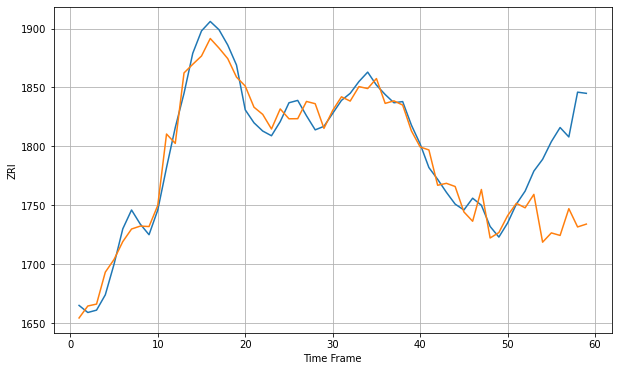

Wall time: 10.7 s
33301 12.219698242433504 64.02184962681419


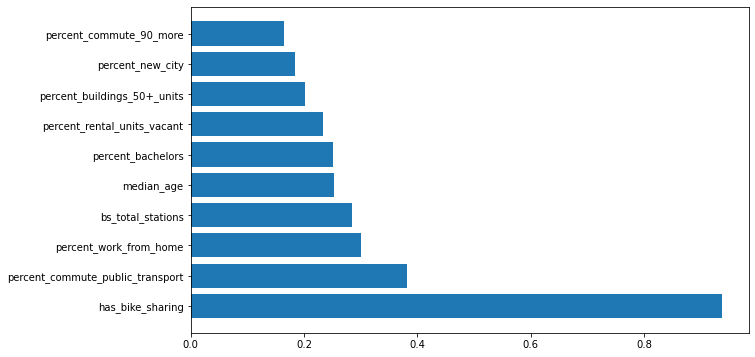


Got an mse at 0.0025 in epoch 68 and stopped training



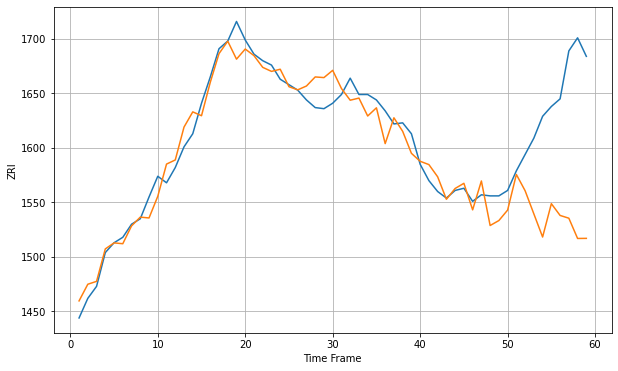

Wall time: 9.45 s
33304 14.14737441736644 101.85215151910418


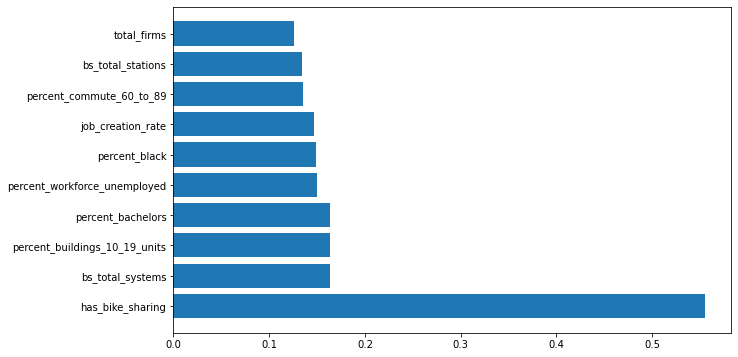


Got an mse at 0.0025 in epoch 47 and stopped training



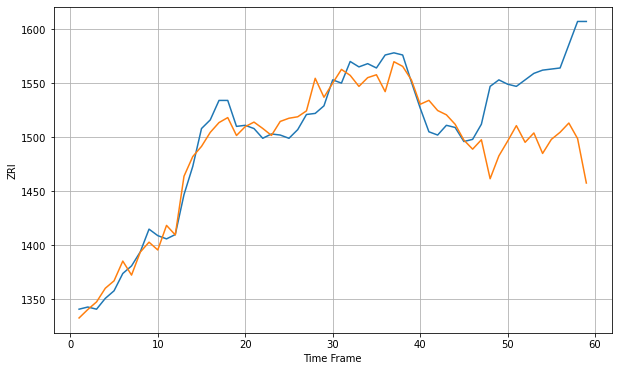

Wall time: 9.76 s
33305 13.317642271337387 79.40126841462991


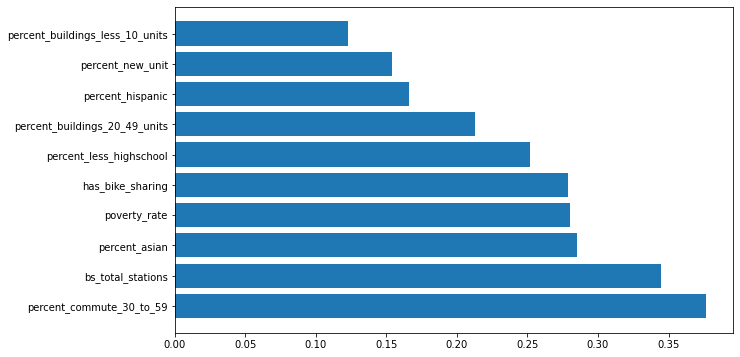


Got an mse at 0.0020 in epoch 16 and stopped training



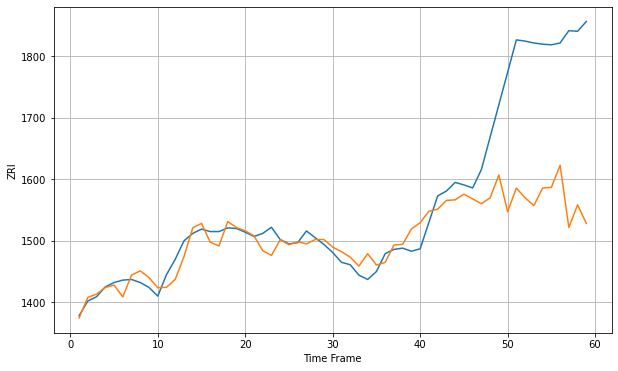

Wall time: 9.12 s
33308 20.56121556763927 242.64525013810757


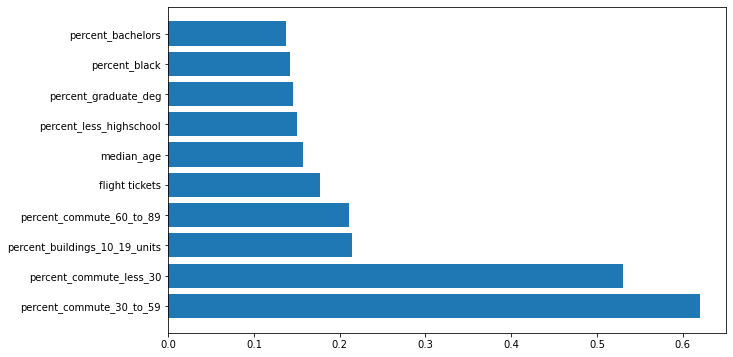


Got an mse at 0.0024 in epoch 28 and stopped training



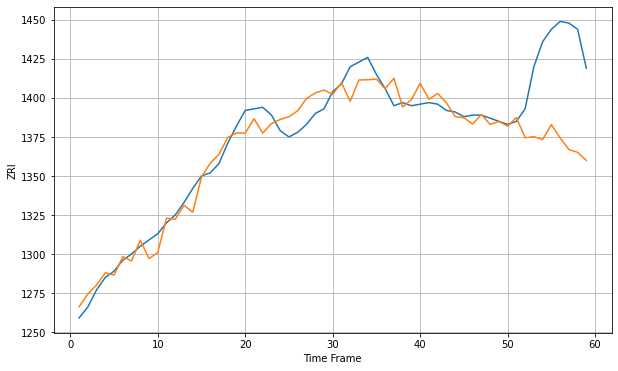

Wall time: 8.66 s
33311 9.064965433620936 51.54497999736533


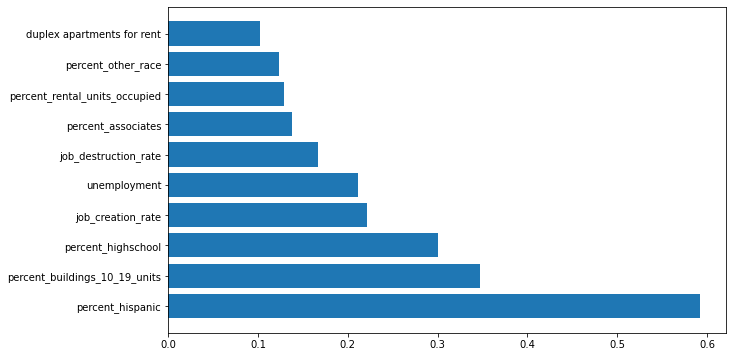


Got an mse at 0.0025 in epoch 55 and stopped training



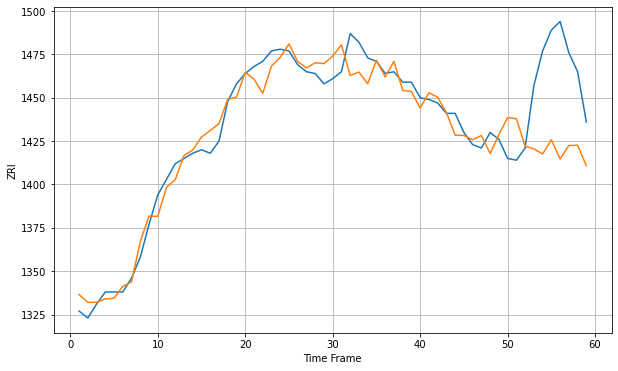

Wall time: 9.61 s
33312 8.690278995839181 42.55024011405035


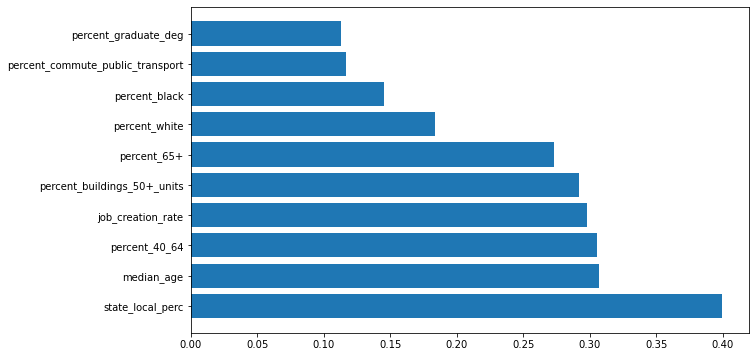


Got an mse at 0.0025 in epoch 26 and stopped training



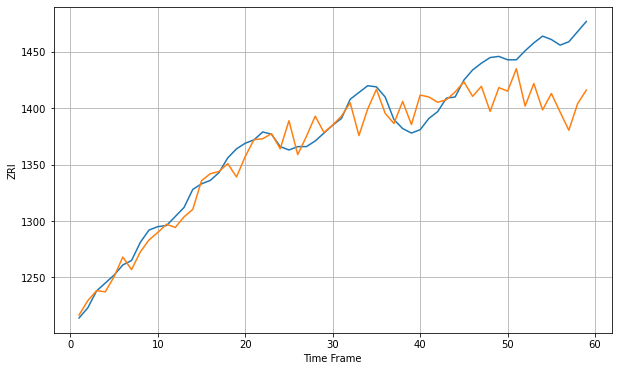

Wall time: 9.92 s
33313 13.187036952061806 51.35038830980194


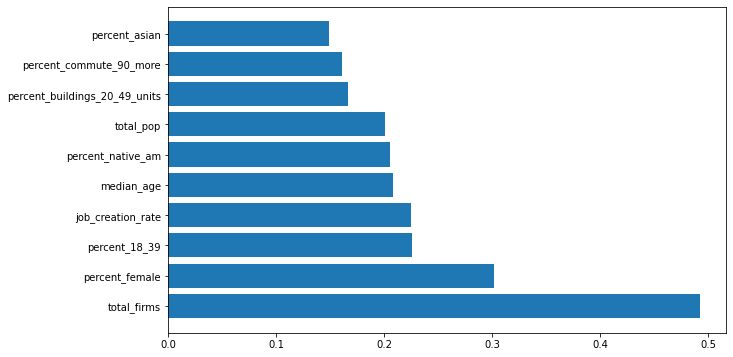


Got an mse at 0.0025 in epoch 40 and stopped training



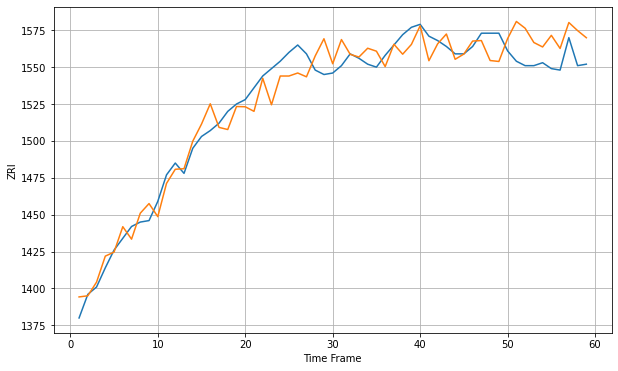

Wall time: 9.33 s
33324 10.53776865235308 18.763441664067834


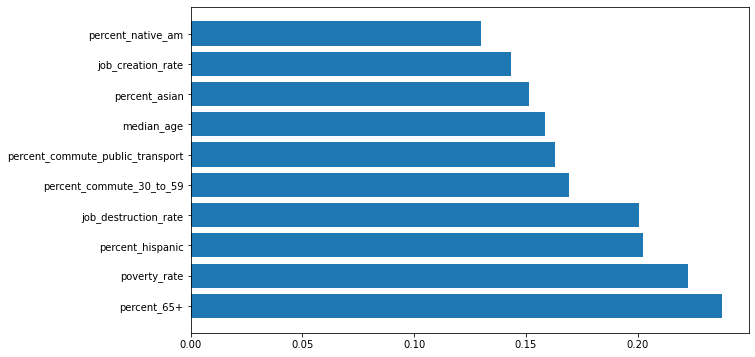


Got an mse at 0.0025 in epoch 20 and stopped training



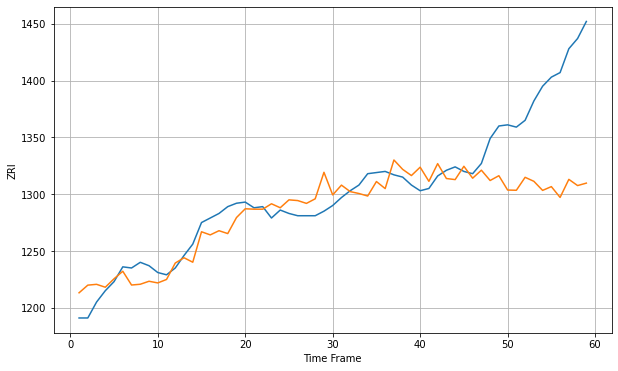

Wall time: 8.32 s
33334 13.127816123056991 89.99194617897386


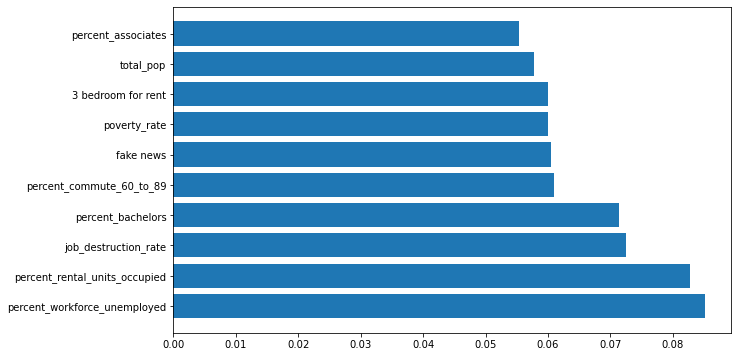


Got an mse at 0.0025 in epoch 42 and stopped training



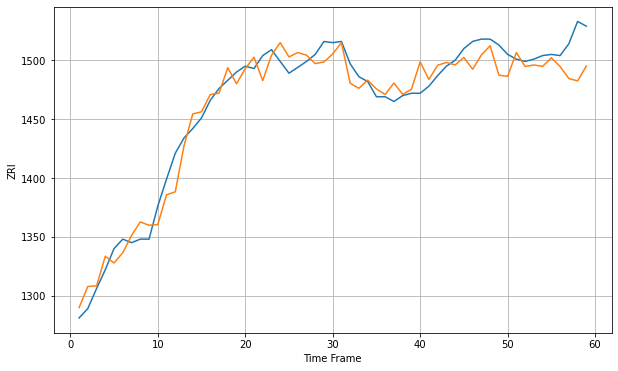

Wall time: 9.54 s
33401 12.378239565751946 22.08771061918937


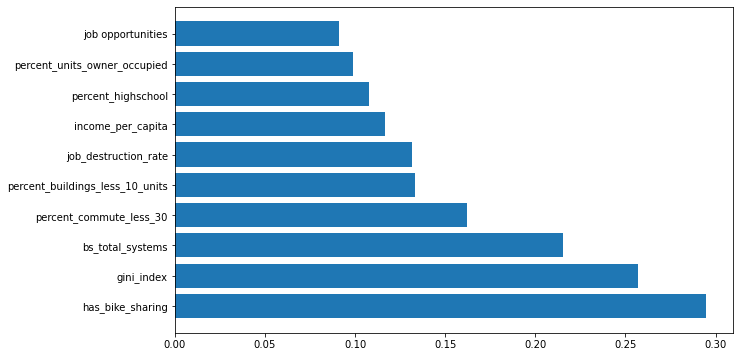


Got an mse at 0.0025 in epoch 71 and stopped training



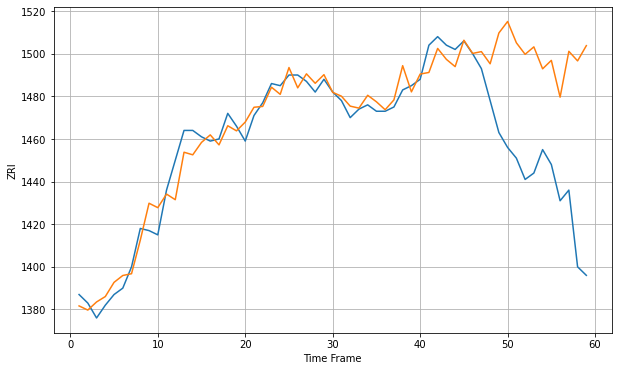

Wall time: 10.1 s
33404 6.503780302257149 62.74221329604827


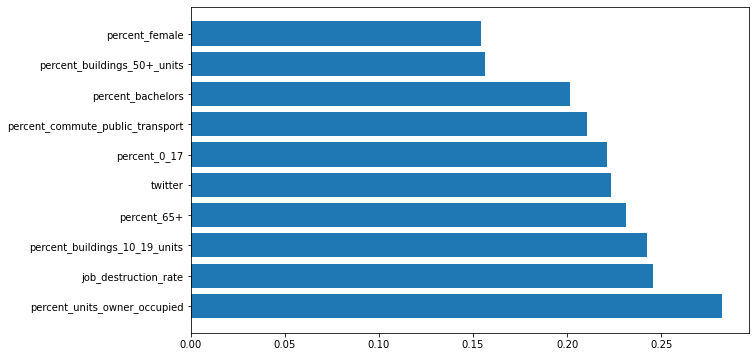


Got an mse at 0.0024 in epoch 48 and stopped training



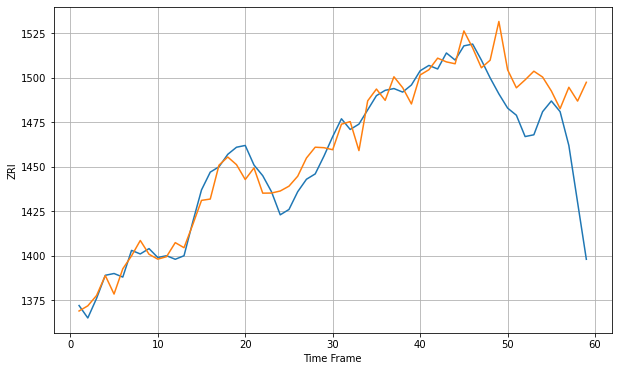

Wall time: 9.6 s
33407 7.665439515095272 40.18724901248464


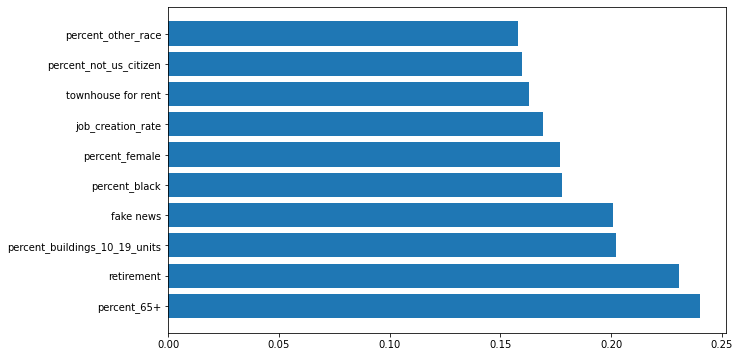


Got an mse at 0.0024 in epoch 101 and stopped training



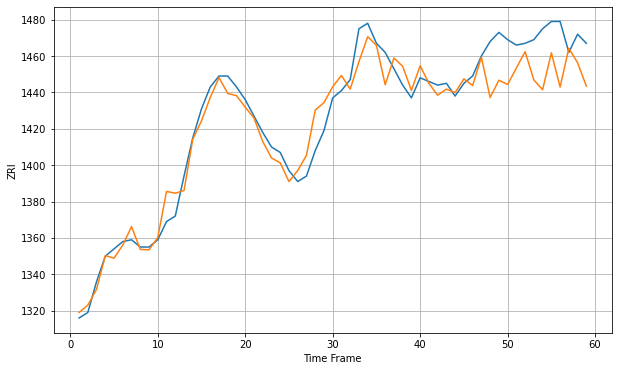

Wall time: 10.7 s
33413 7.9652807248654405 23.181748730158038


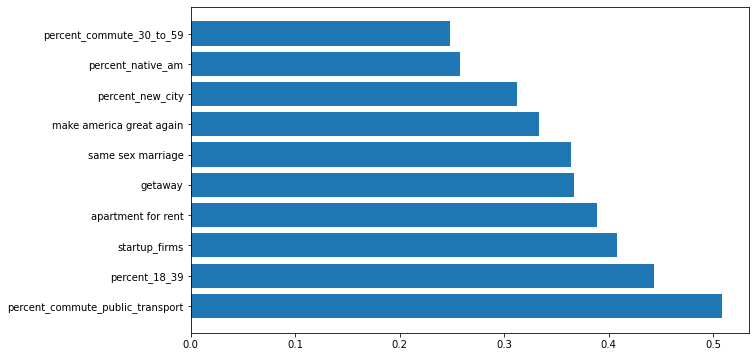


Got an mse at 0.0025 in epoch 113 and stopped training



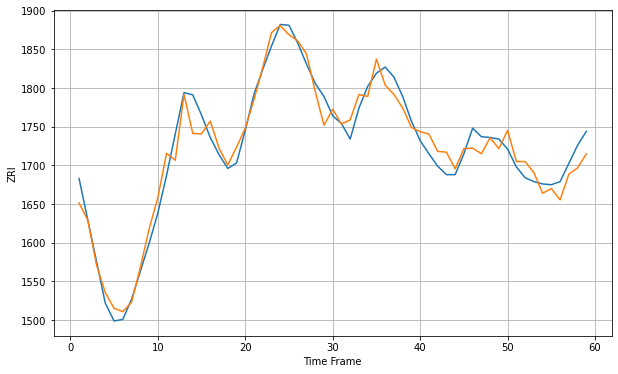

Wall time: 11.2 s
33414 18.78411669674486 18.202349451452044


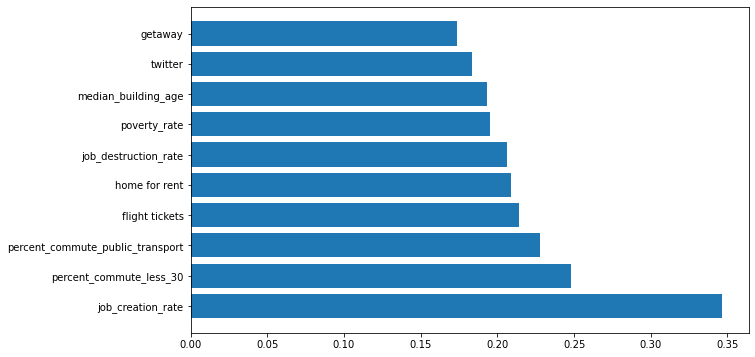


Got an mse at 0.0024 in epoch 44 and stopped training



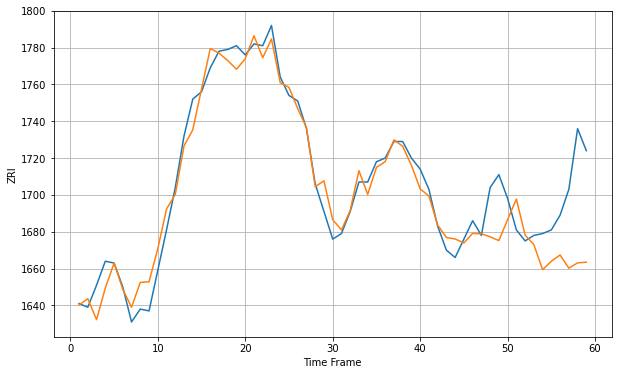

Wall time: 9.05 s
33418 8.018548842746219 34.635158428529635


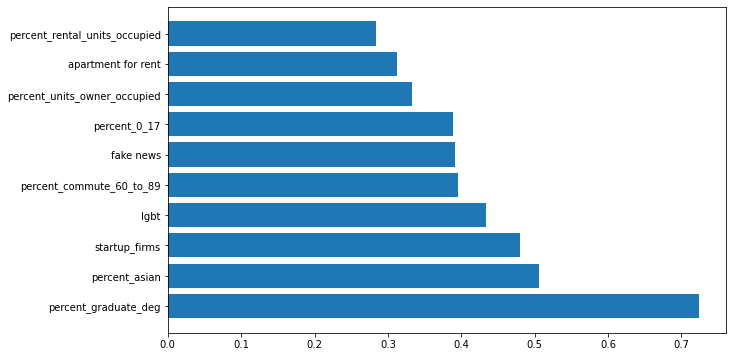


Got an mse at 0.0025 in epoch 83 and stopped training



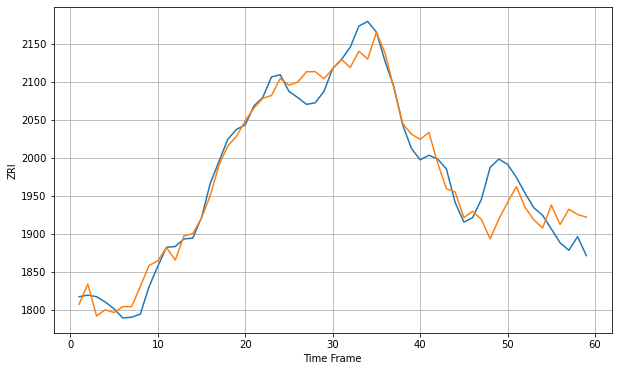

Wall time: 10.6 s
33432 19.266056424402944 46.96546249599978


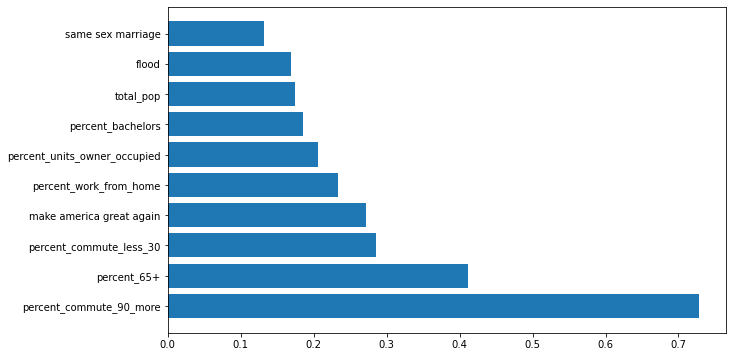


Got an mse at 0.0025 in epoch 74 and stopped training



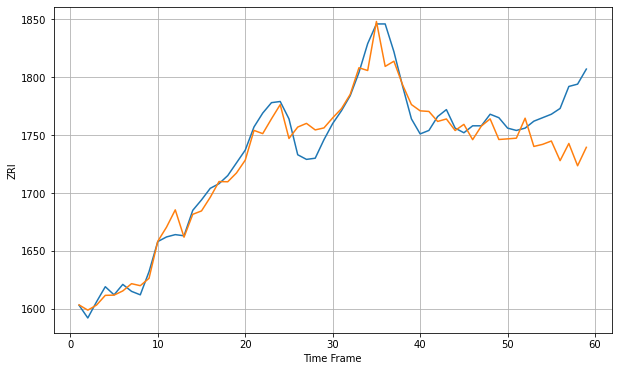

Wall time: 10.3 s
33433 12.475037330444058 36.647955236006524


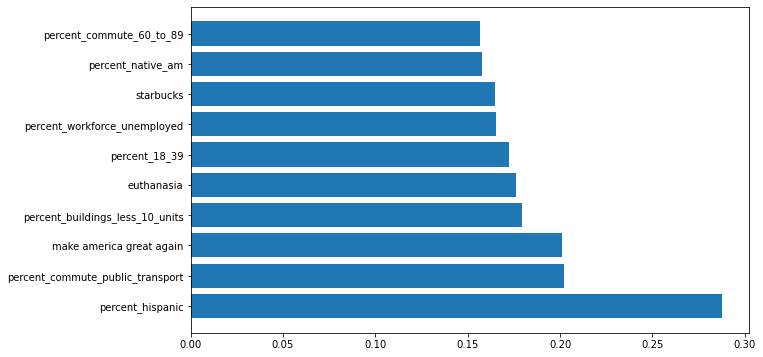


Got an mse at 0.0025 in epoch 92 and stopped training



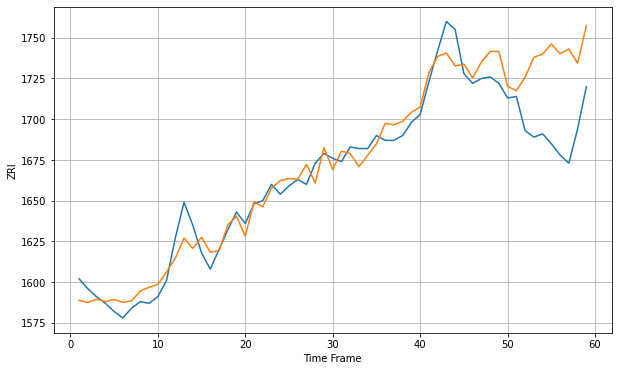

Wall time: 10.5 s
33435 9.052181143137584 42.9295594176787


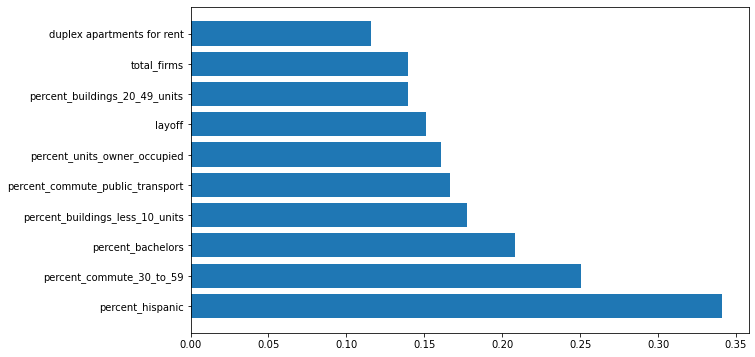


Got an mse at 0.0025 in epoch 162 and stopped training



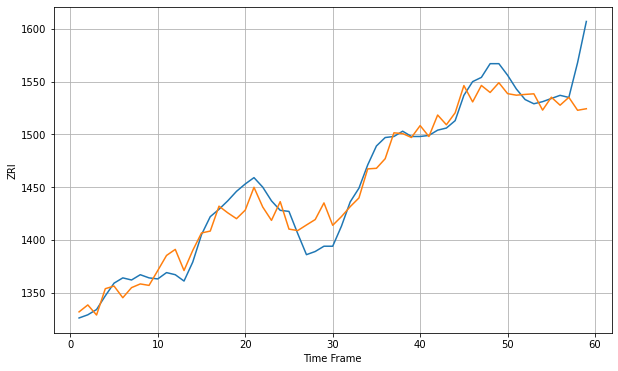

Wall time: 13 s
33436 14.845485859226844 29.657827563215392


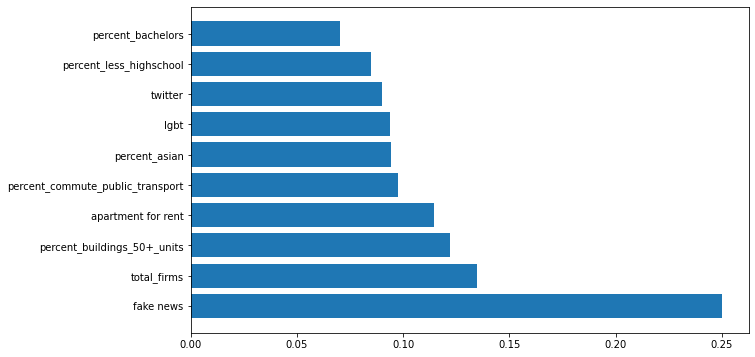


Got an mse at 0.0025 in epoch 168 and stopped training



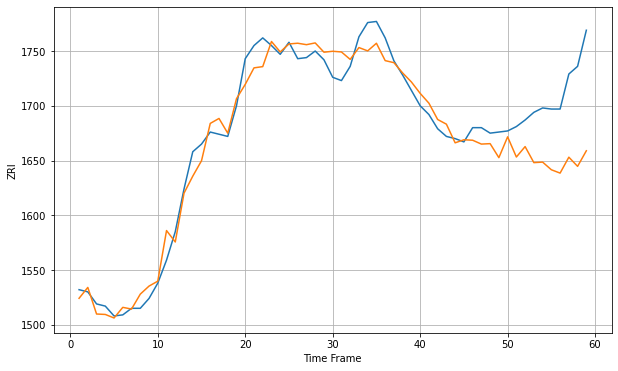

Wall time: 12.9 s
33444 13.311138109674342 57.245211165885564


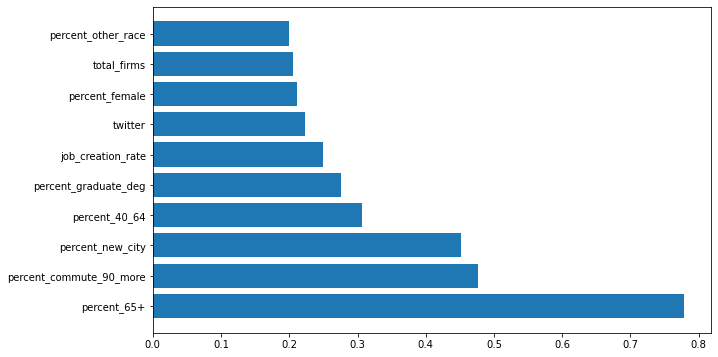


Got an mse at 0.0025 in epoch 166 and stopped training



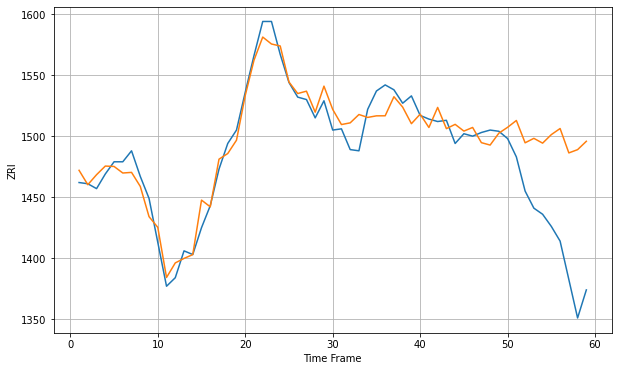

Wall time: 12.9 s
33460 12.02489027366683 75.37742759874101


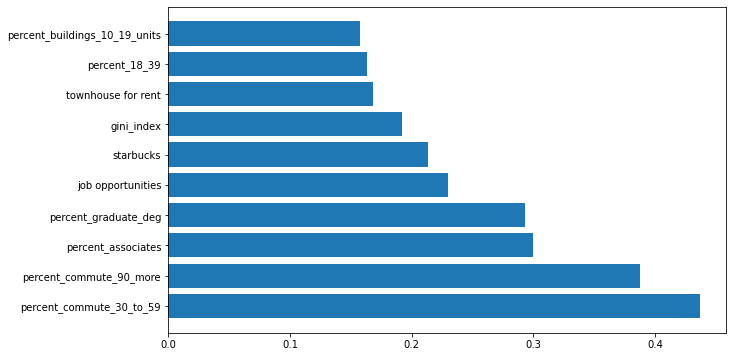


Got an mse at 0.0025 in epoch 105 and stopped training



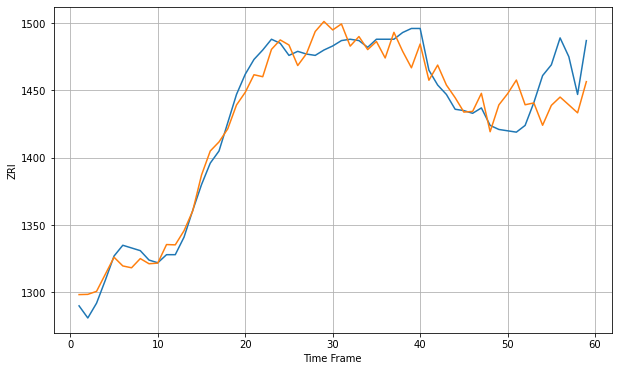

Wall time: 11 s
33461 10.636199132879304 28.048883588764483


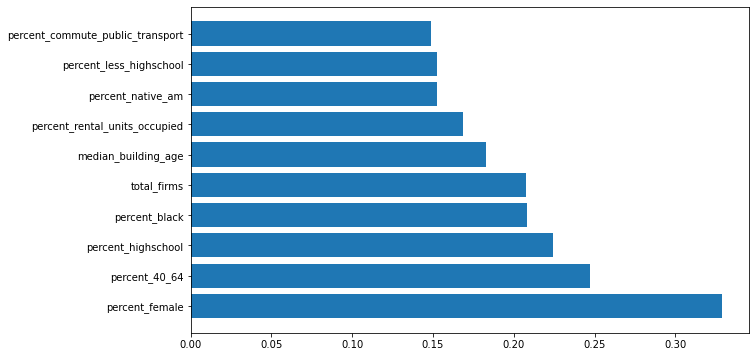


Got an mse at 0.0025 in epoch 67 and stopped training



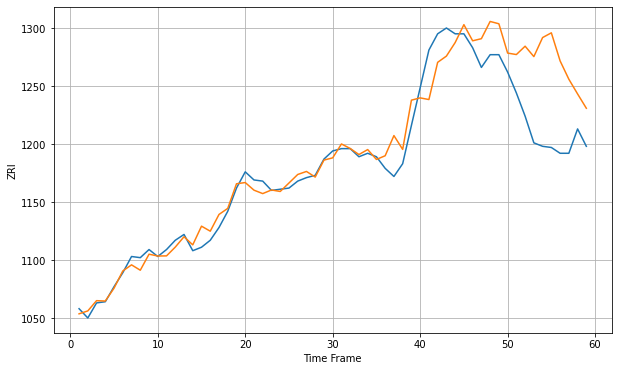

Wall time: 10 s
33510 12.34781220167375 59.8862811758607


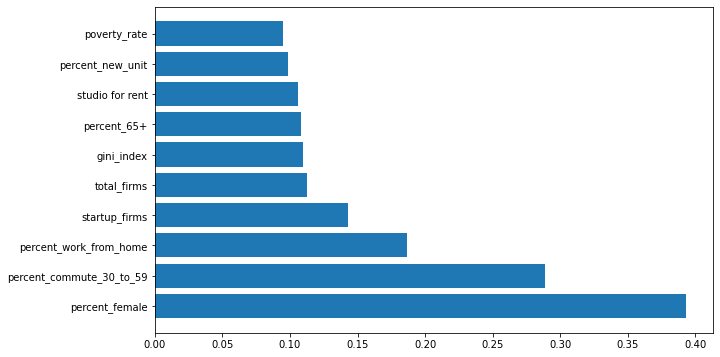


Got an mse at 0.0025 in epoch 92 and stopped training



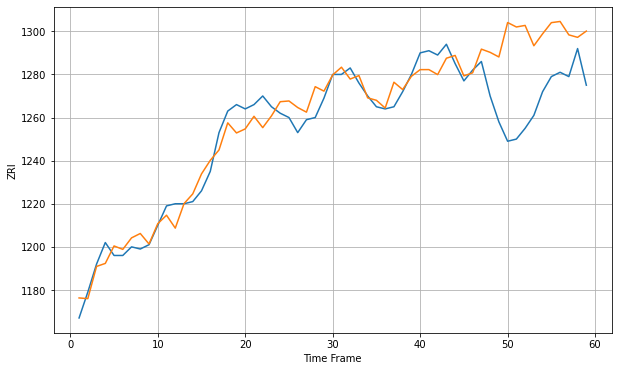

Wall time: 10.7 s
33511 6.700044067991131 33.30749136801663


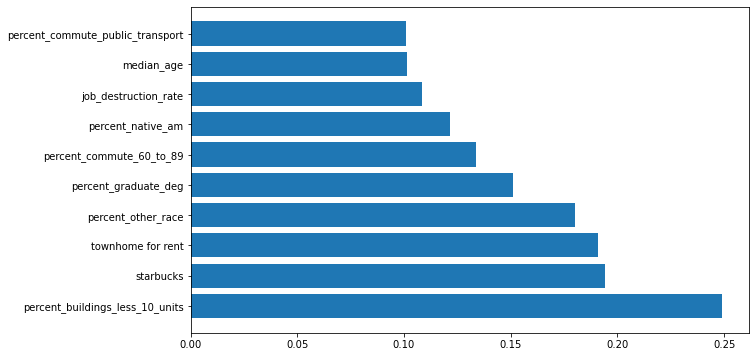


Got an mse at 0.0025 in epoch 70 and stopped training



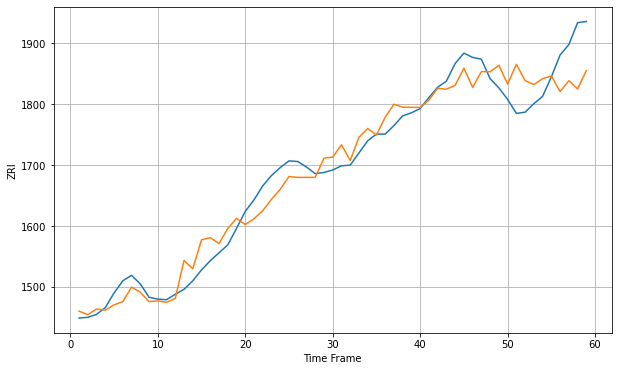

Wall time: 10.1 s
33602 24.546316512993776 56.723911498728015


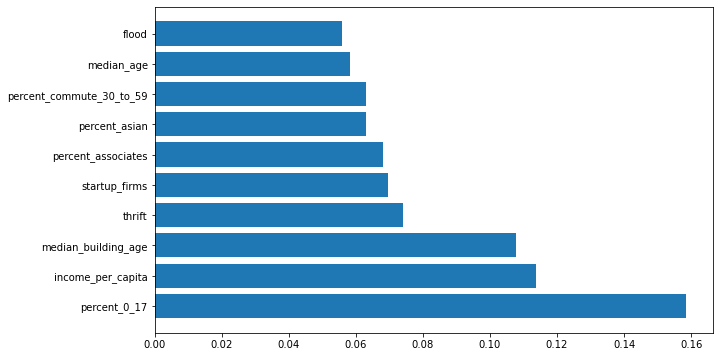


Got an mse at 0.0025 in epoch 72 and stopped training



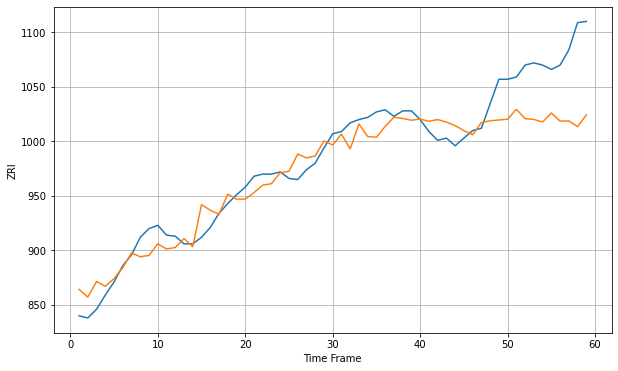

Wall time: 10.9 s
33604 13.653036688367916 55.2717278970615


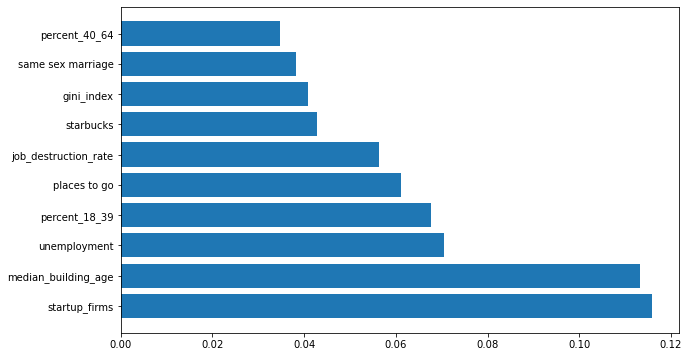


Got an mse at 0.0024 in epoch 39 and stopped training



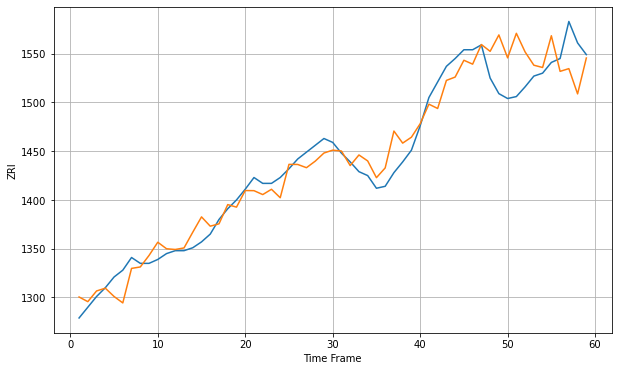

Wall time: 9 s
33606 14.86129519912604 38.465249824075784


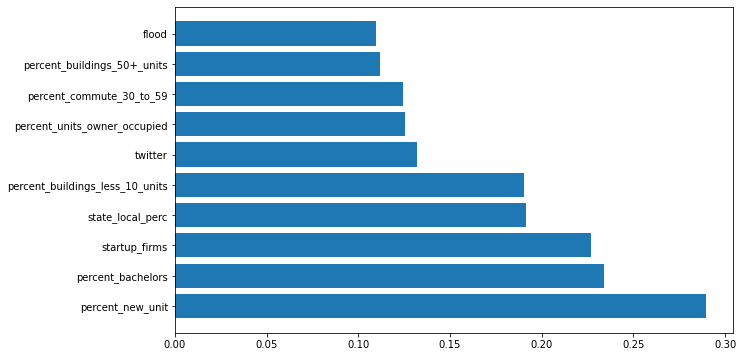


Got an mse at 0.0025 in epoch 97 and stopped training



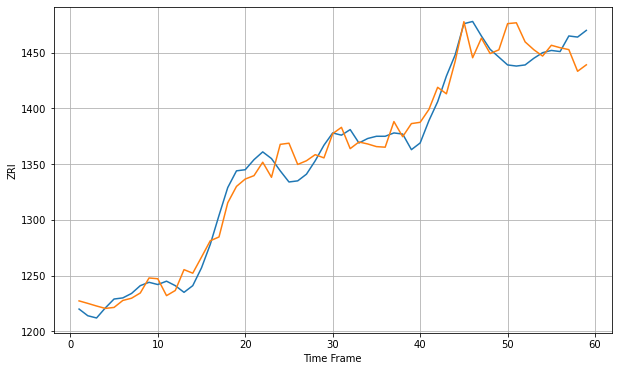

Wall time: 11.1 s
33607 13.170002720122172 21.433961181266508


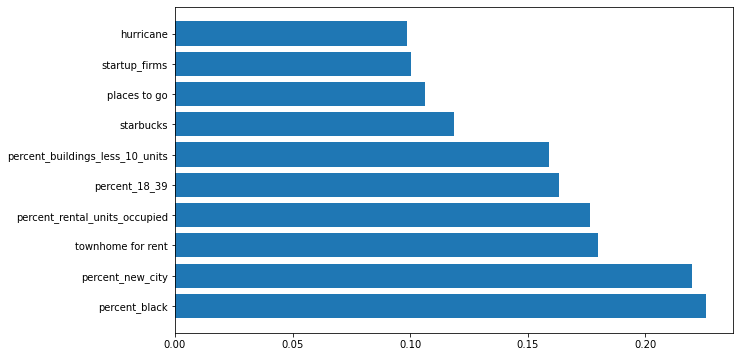


Got an mse at 0.0024 in epoch 25 and stopped training



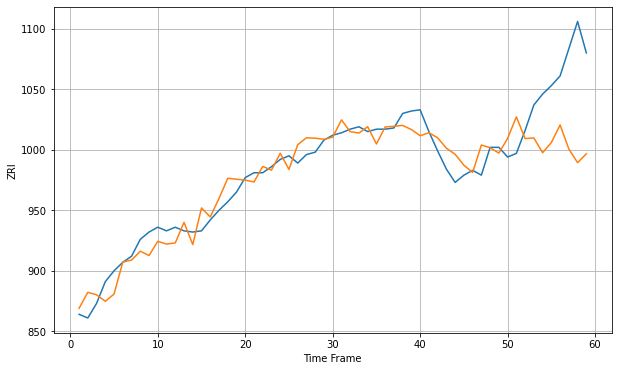

Wall time: 8.64 s
33612 11.975706720771344 54.45952614272651


In [ ]:
score_dict = {"zip":[], "RMSE_train":[], "RMSE_test":[], "importance":[]};
with tf.device('/cpu:0'):
    # for ZONE in zip_ids:
    for ZONE in zip_ids[START_NUM:END_NUM]:
        %time M_train, M_test, model, scaler, series_transformed =\
        NN_test(ZONE, termination=0.0025, plot=True);
        print(ZONE, M_train, M_test);

        score_dict["zip"].append(ZONE);
        score_dict["RMSE_train"].append(M_train);
        score_dict["RMSE_test"].append(M_test);
        
        # Computing the feature importance
        
        results, actual = NN_forecast(model, series_transformed);
        mse = mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5;
        perm_importance = [];
        TRIALS = 2;
        PLOT_IMPORTANCE = True;
        
        for i in range(1, len(feature_name)):
            mse_feat = [];
            for _ in range(TRIALS):
                seq_perm = series_transformed.copy();
                seq_perm[:, i] = np.random.permutation(seq_perm[:,i])
                results, actual = NN_forecast(model, seq_perm);
                mse_feat.append(mean_squared_error(actual[:-TEST_LENGTH], results[:-TEST_LENGTH])**0.5);
                
            perm_importance.append(sum(mse_feat)/TRIALS/mse - 1.0);
        
        importance = pd.DataFrame({"Feature": feature_name[1:], "Importance": perm_importance});
        importance.sort_values("Importance", ascending = False, inplace = True);
        
        plt.figure(figsize=(10, 6));
        plt.barh(importance["Feature"][:10], importance["Importance"][:10]);
        plt.show();
        
        score_dict["importance"].append(perm_importance);

In [ ]:
print(sum(score_dict["RMSE_test"])/len(score_dict["RMSE_test"]));

In [ ]:
test = pd.DataFrame(score_dict);
test.to_csv('NN_feature_window_1_overoverfit_importance_5.csv', index = False);